The objective of this project is to predict whether an individula's income fall below or above $50,000 using US census data. The original dataset conains approximately 33,000 records, 25,000 of them were used for traning and validating purposes, while the rest was stored as a separate csv file (to prevent any kind of data leakage) for final testing.

The final Gradient Boosting Classifier model achieves 86.858% overall accuracy, 1.43% lower than best results found on Kaggle. https://www.kaggle.com/uciml/adult-census-income/kernels

The project uses over 10 different models to test which one is the most approriate for the underlying classification task, and fine tunes the optimal model.

# Getting Started

## Import Packages

In [1]:
import pandas as pd

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from eli5.sklearn import PermutationImportance

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

##Set plot font sizes
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=28)  
plt.rc('figure', titlesize=28)  # fontsize of the figure title

pd.options.mode.chained_assignment = None

pd.set_option('display.max_columns', 500)

Using TensorFlow backend.
C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Read data

In [2]:
full_train = pd.read_csv("training.csv")
full_test = pd.read_csv("test2.csv")
target = "income"
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             25000 non-null  int64 
 1   workclass       25000 non-null  object
 2   demogweight     25000 non-null  int64 
 3   education       25000 non-null  object
 4   education-num   25000 non-null  int64 
 5   marital-status  25000 non-null  object
 6   occupation      25000 non-null  object
 7   relationship    25000 non-null  object
 8   race            25000 non-null  object
 9   sex             25000 non-null  object
 10  capital-gain    25000 non-null  int64 
 11  capital-loss    25000 non-null  int64 
 12  hours-per-week  25000 non-null  int64 
 13  native-country  25000 non-null  object
 14  income          25000 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.9+ MB


Sorting one list by another code: https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list

## EDA

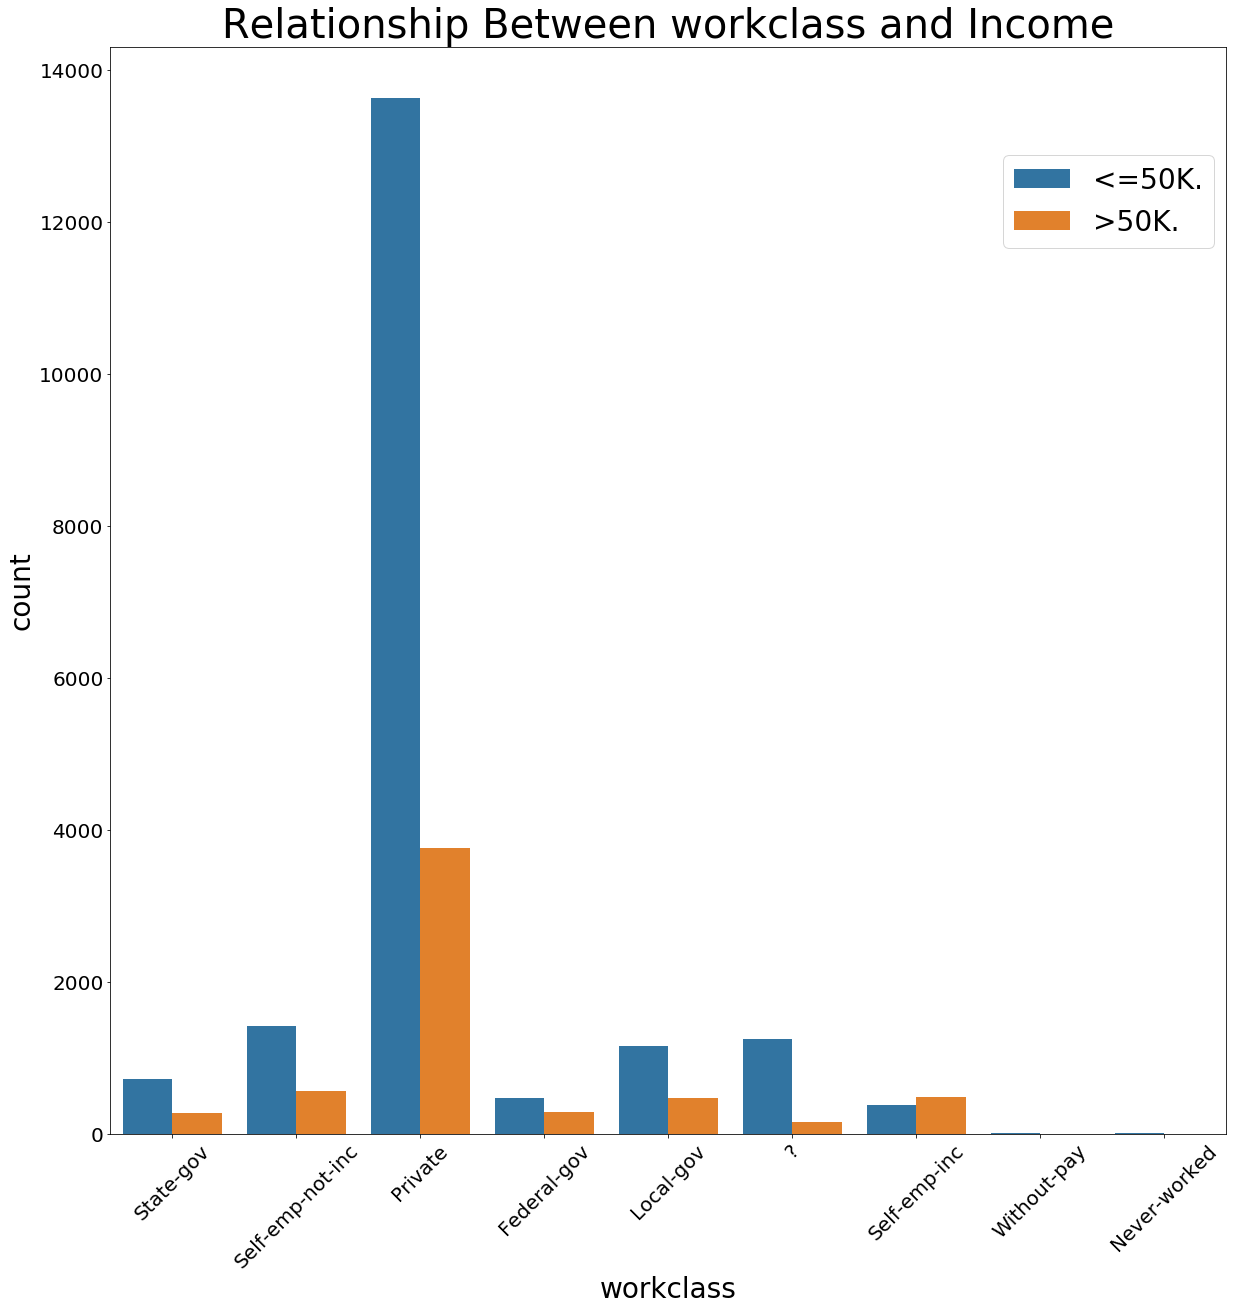

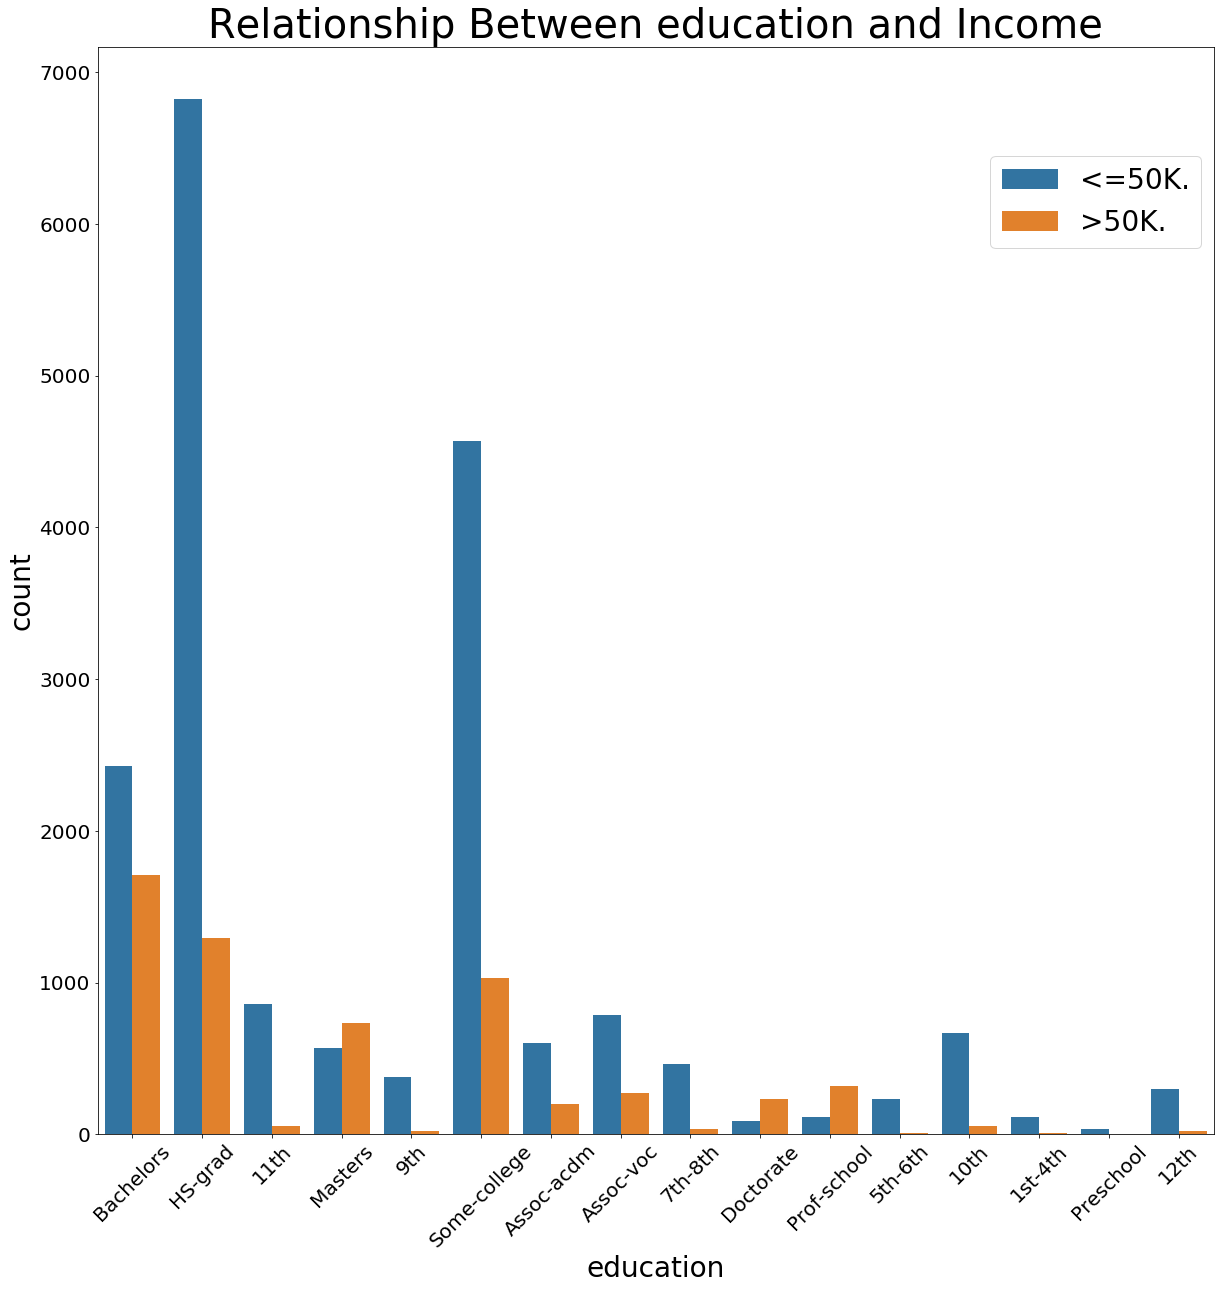

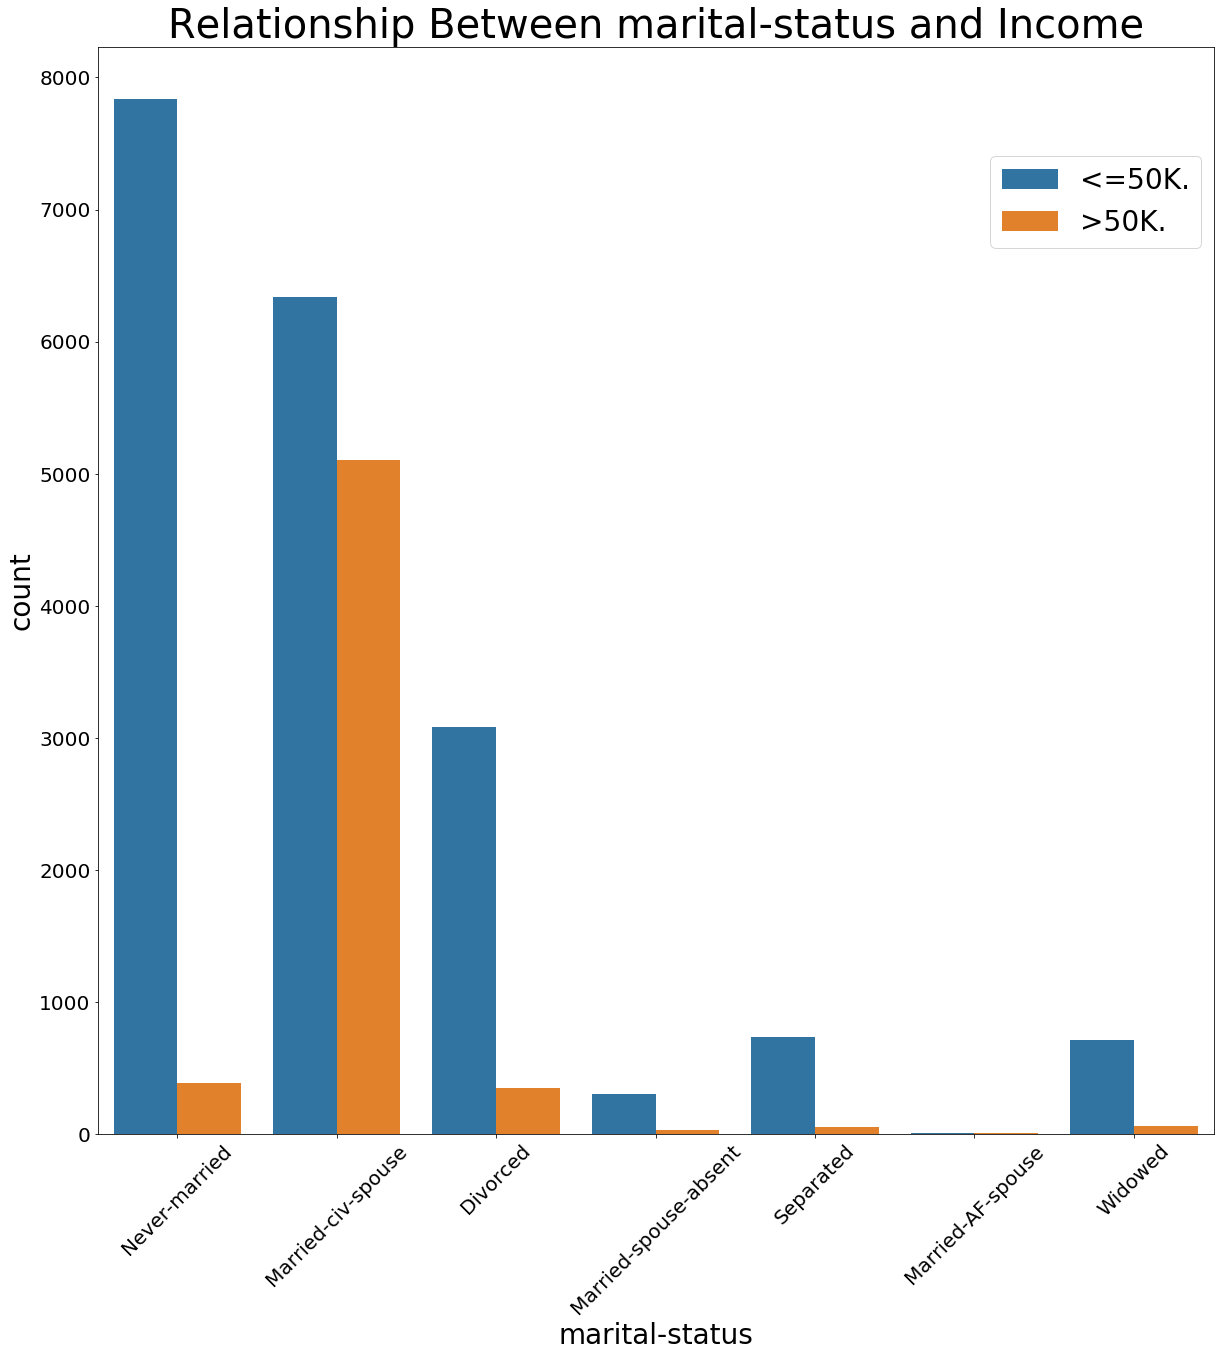

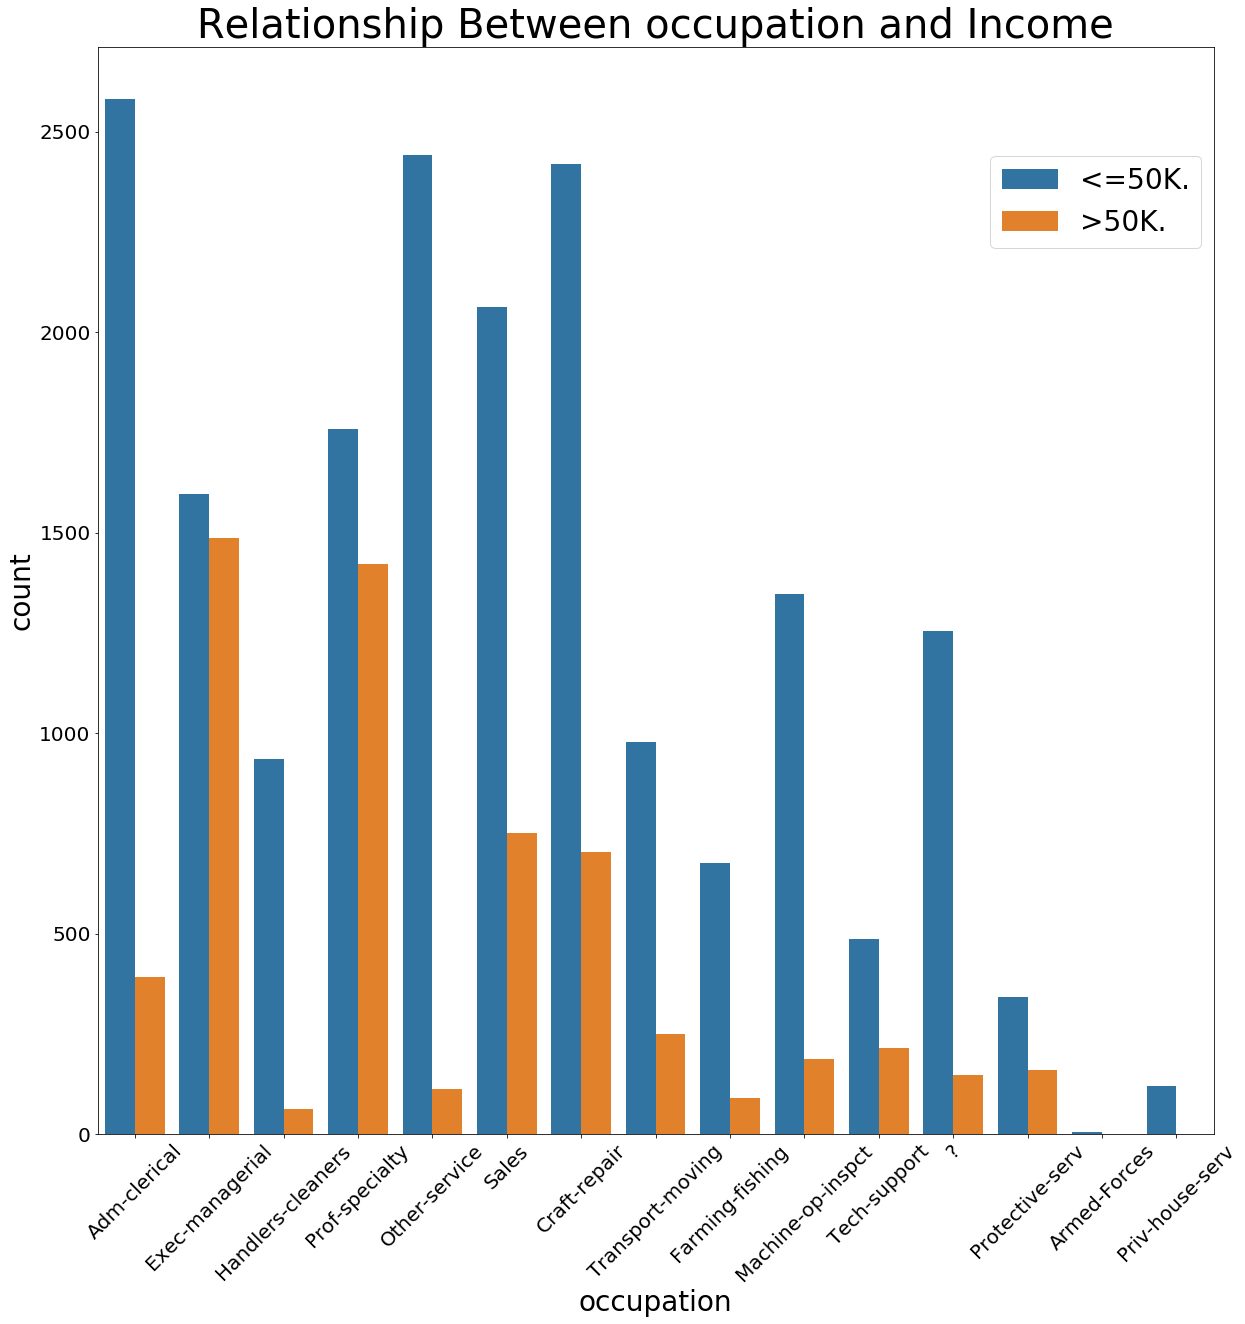

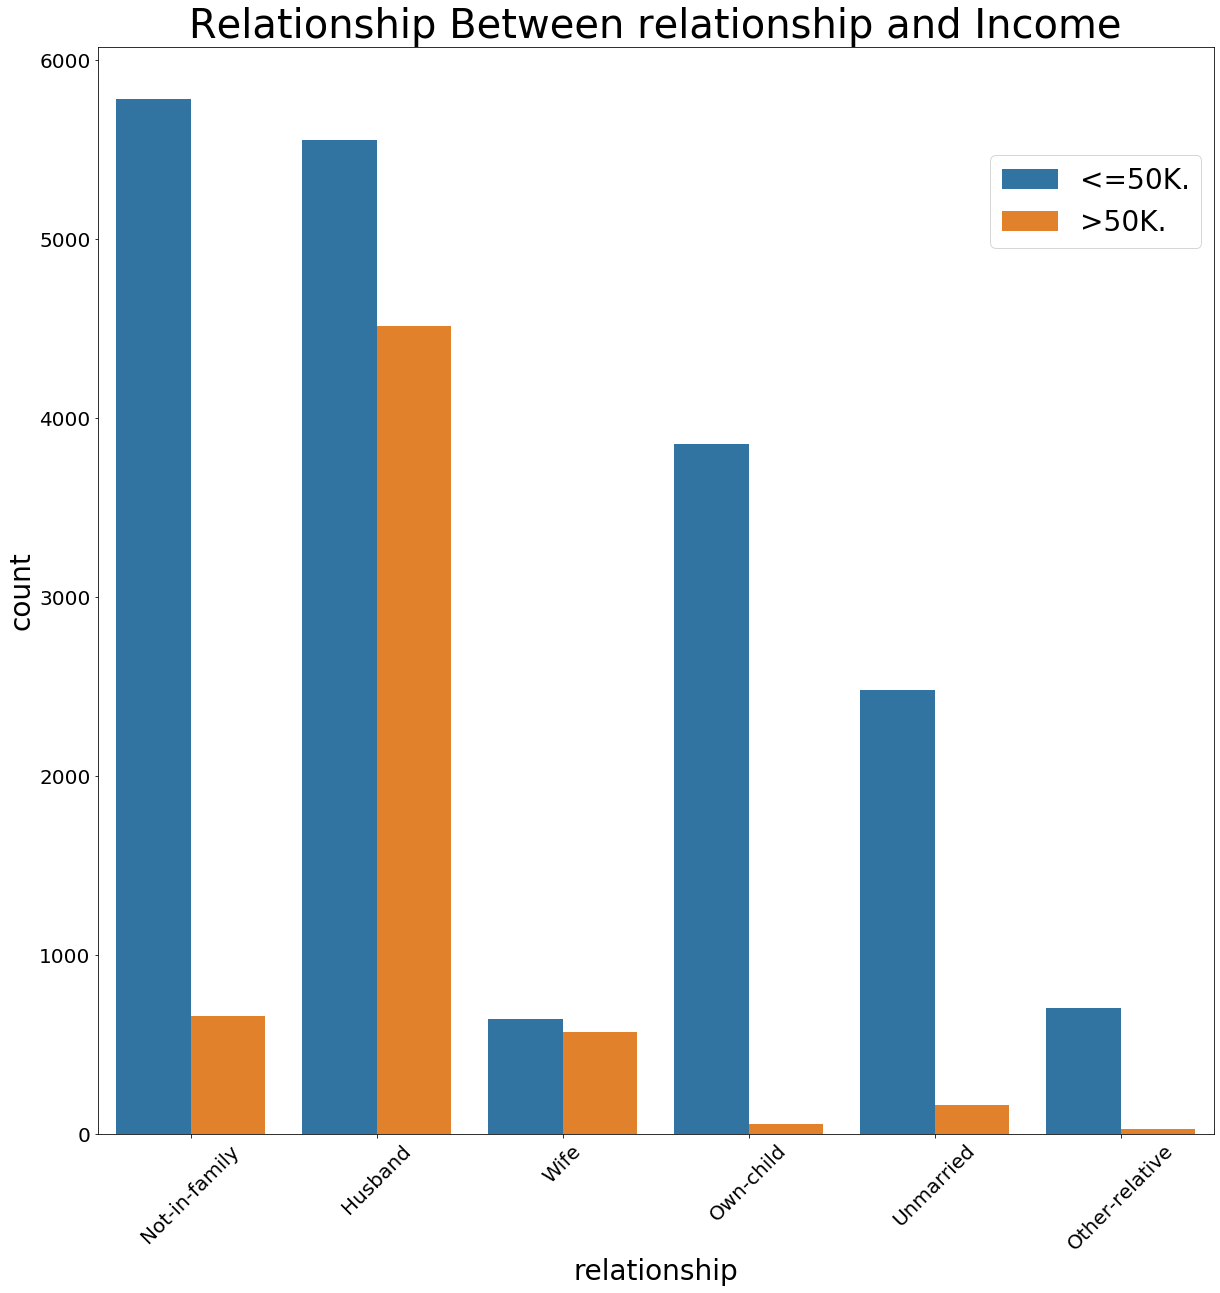

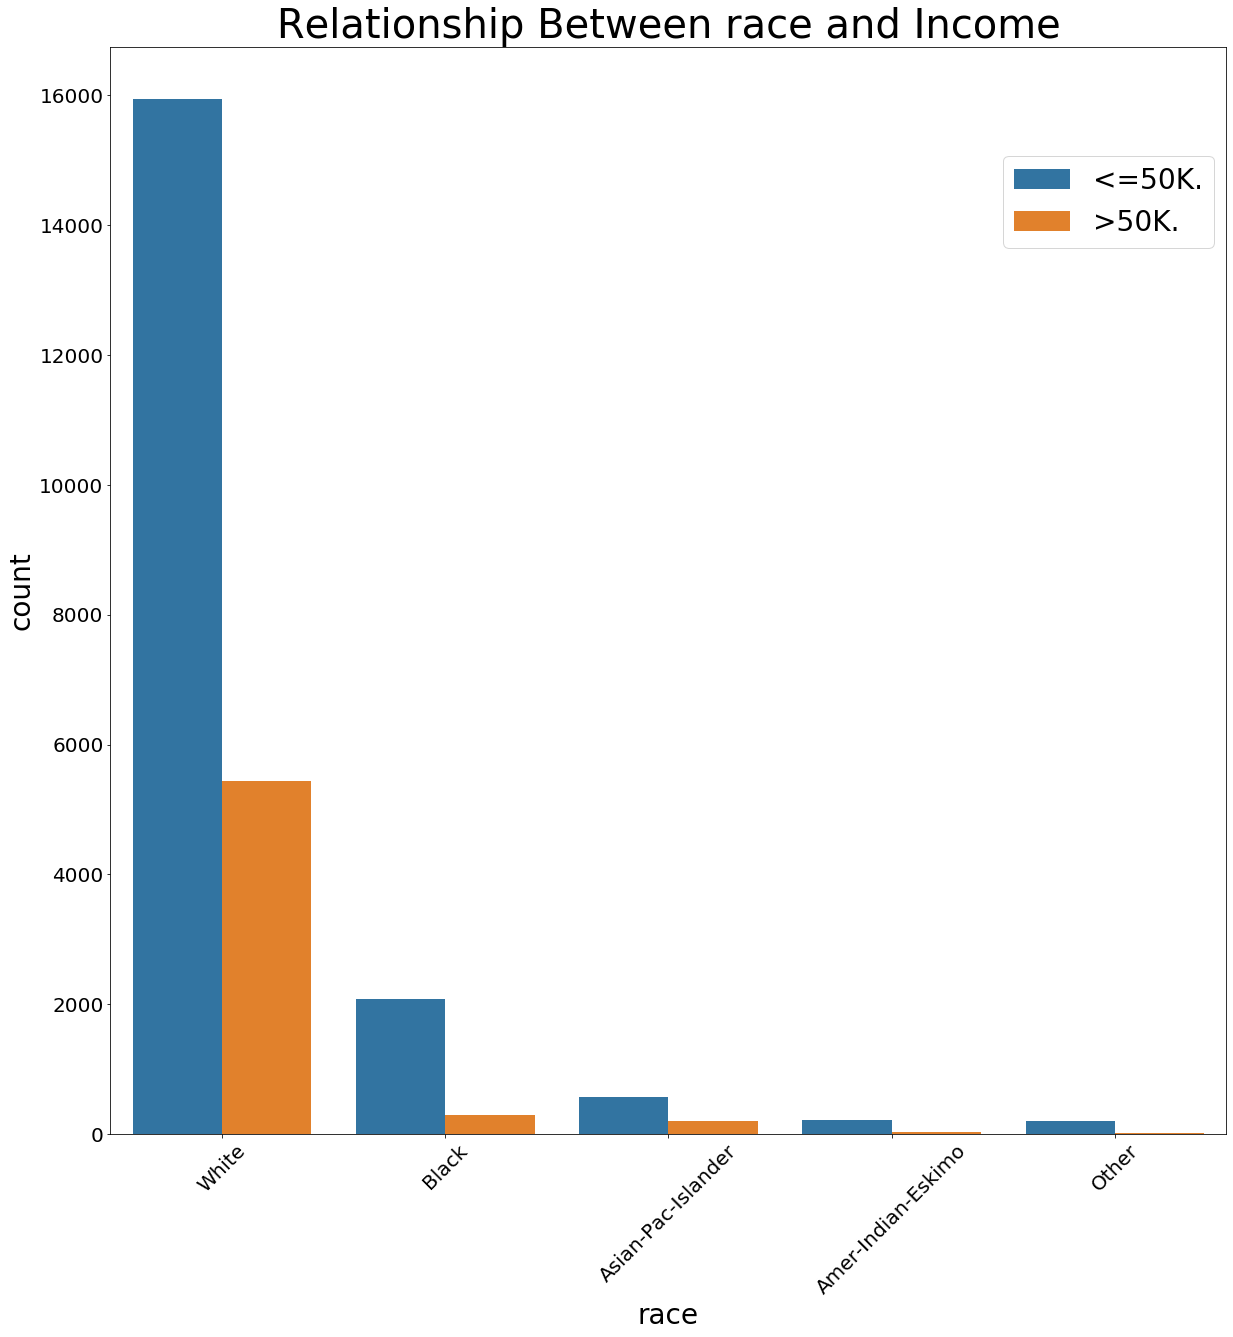

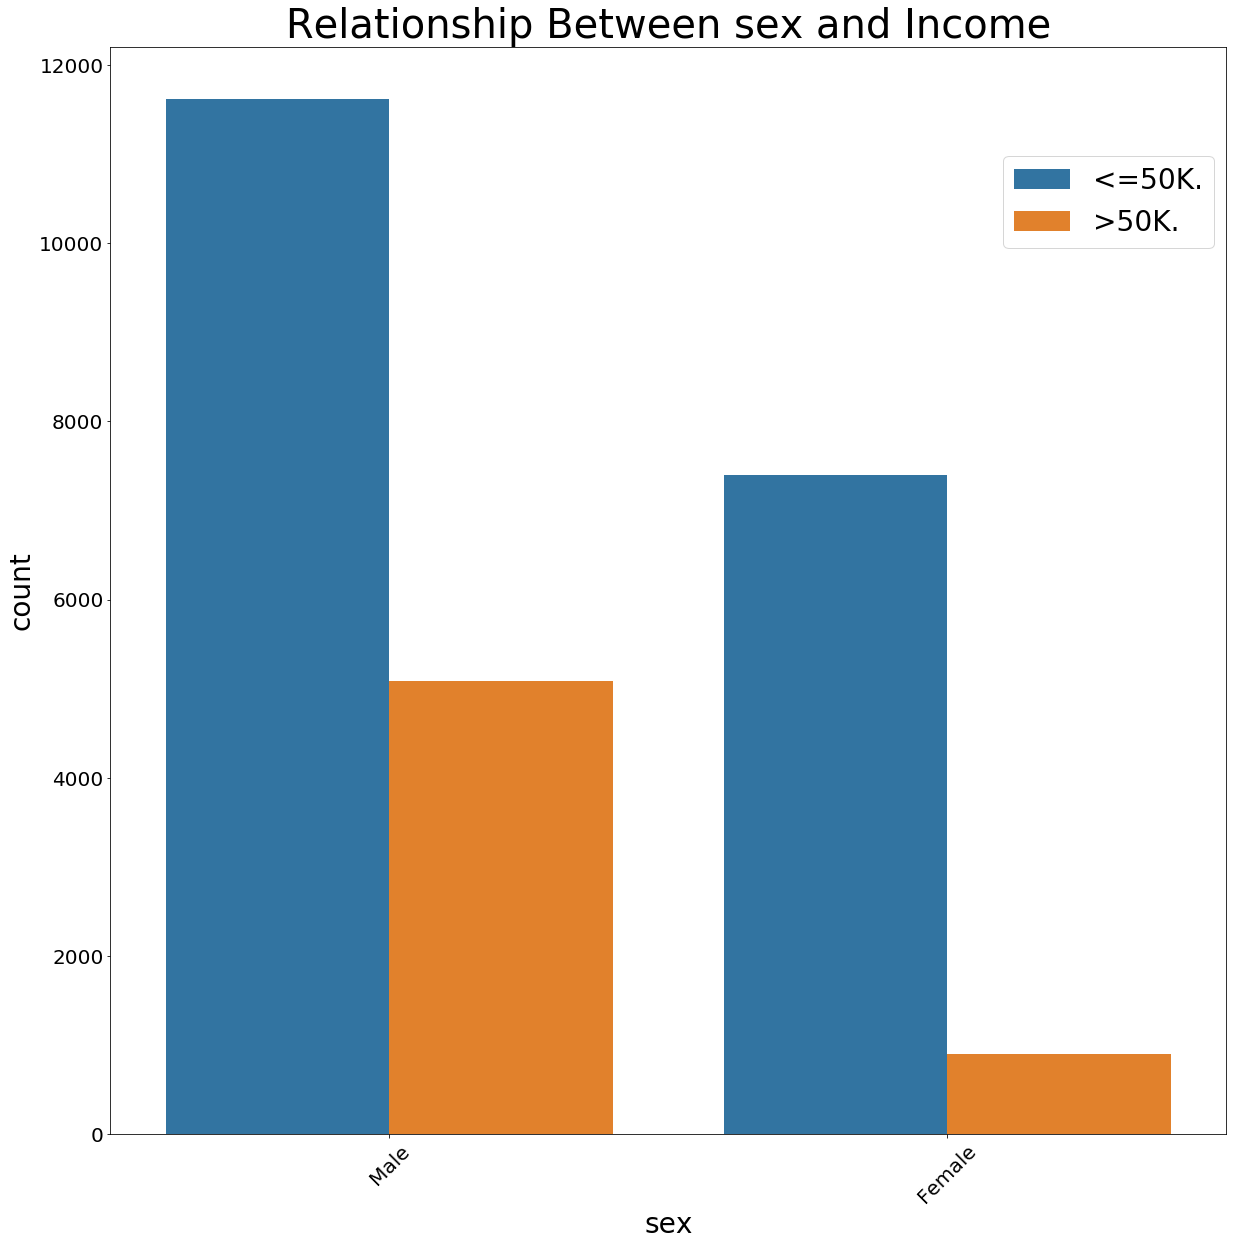

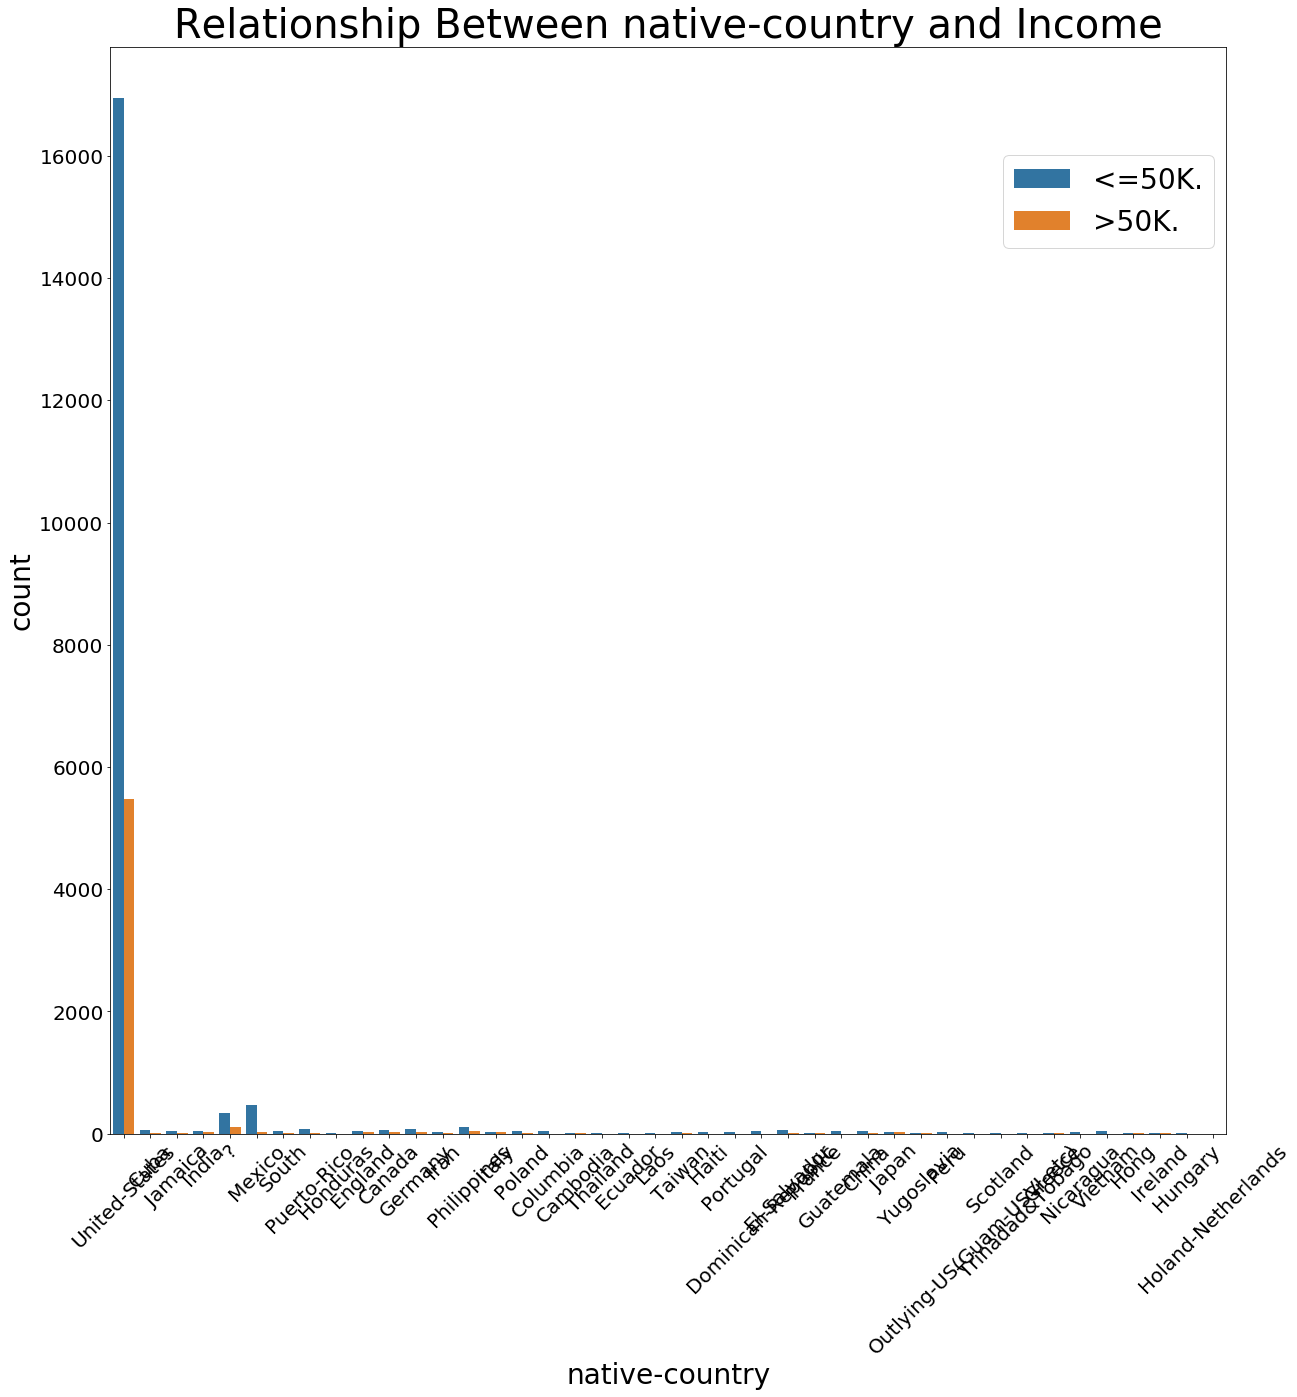

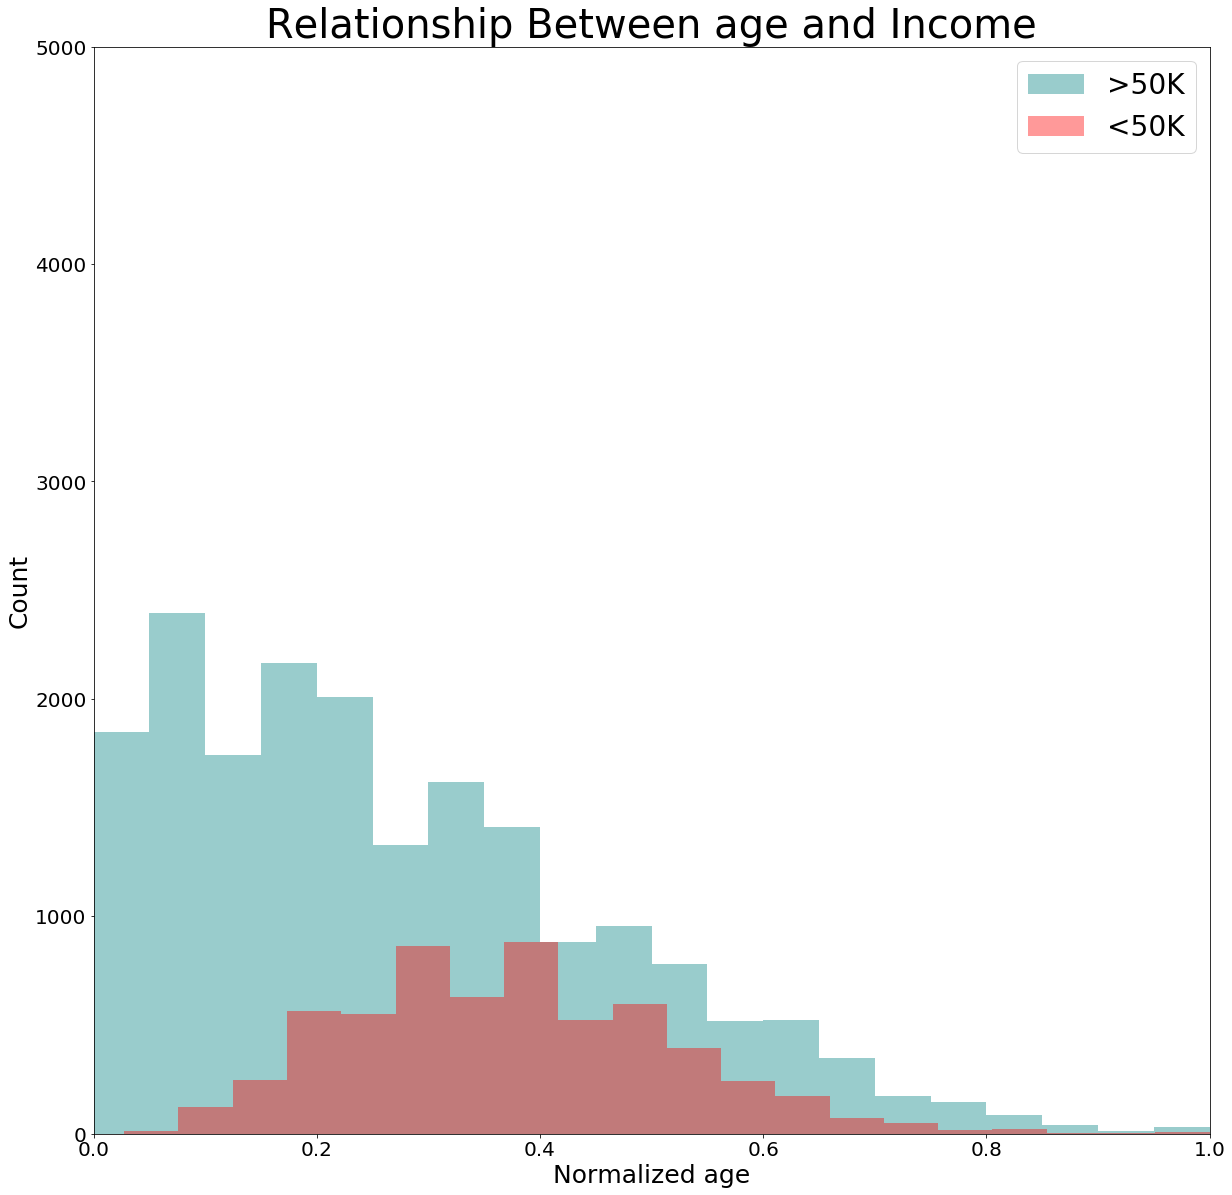

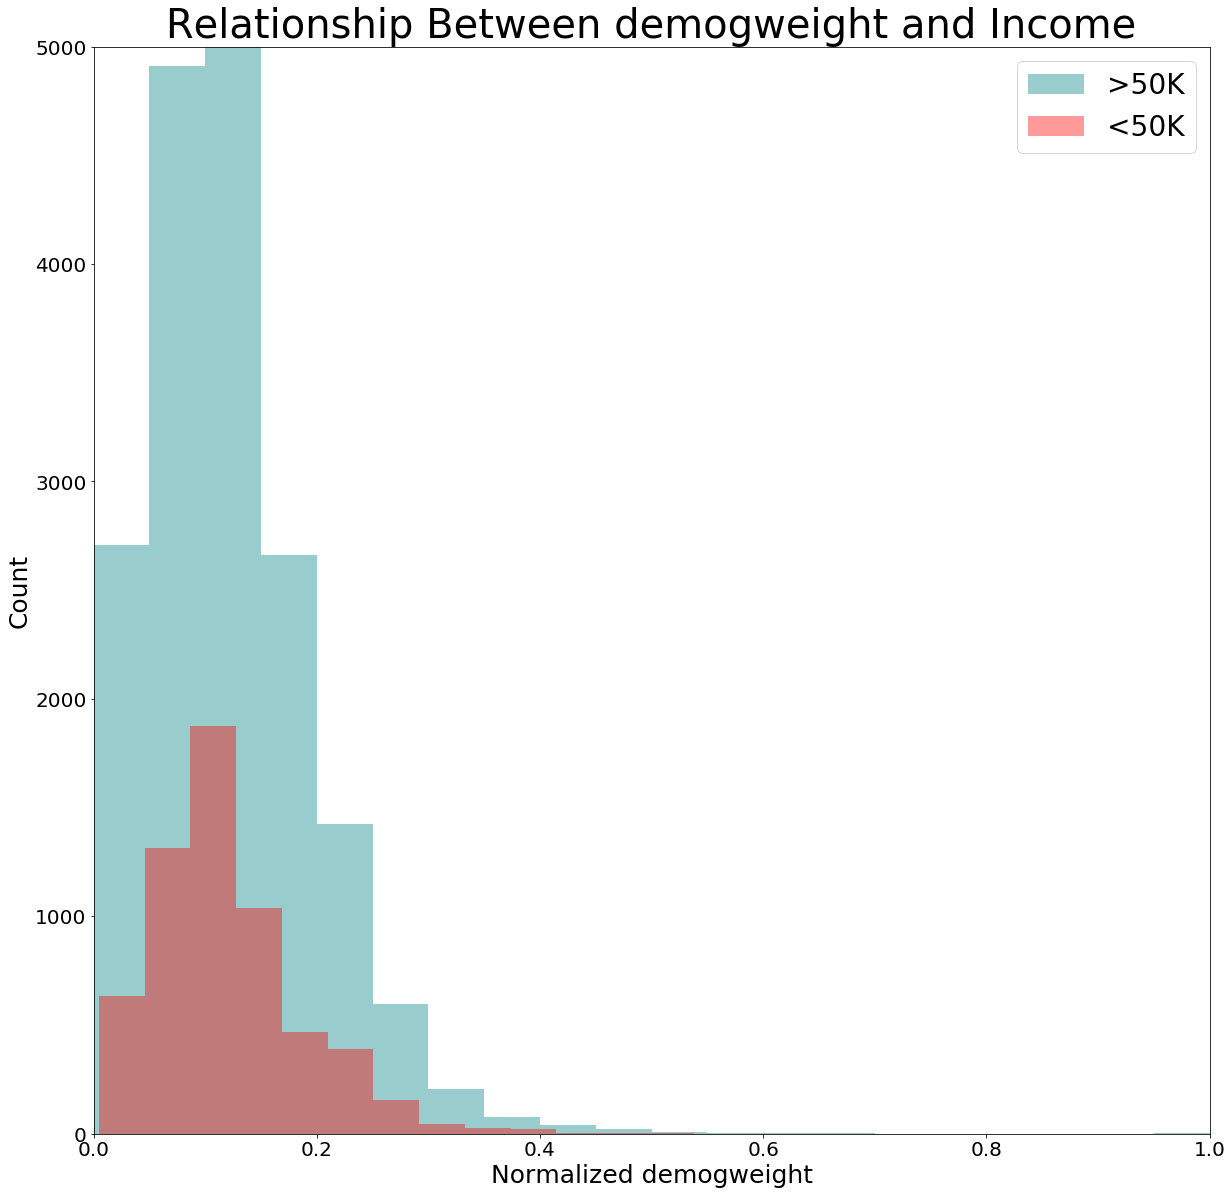

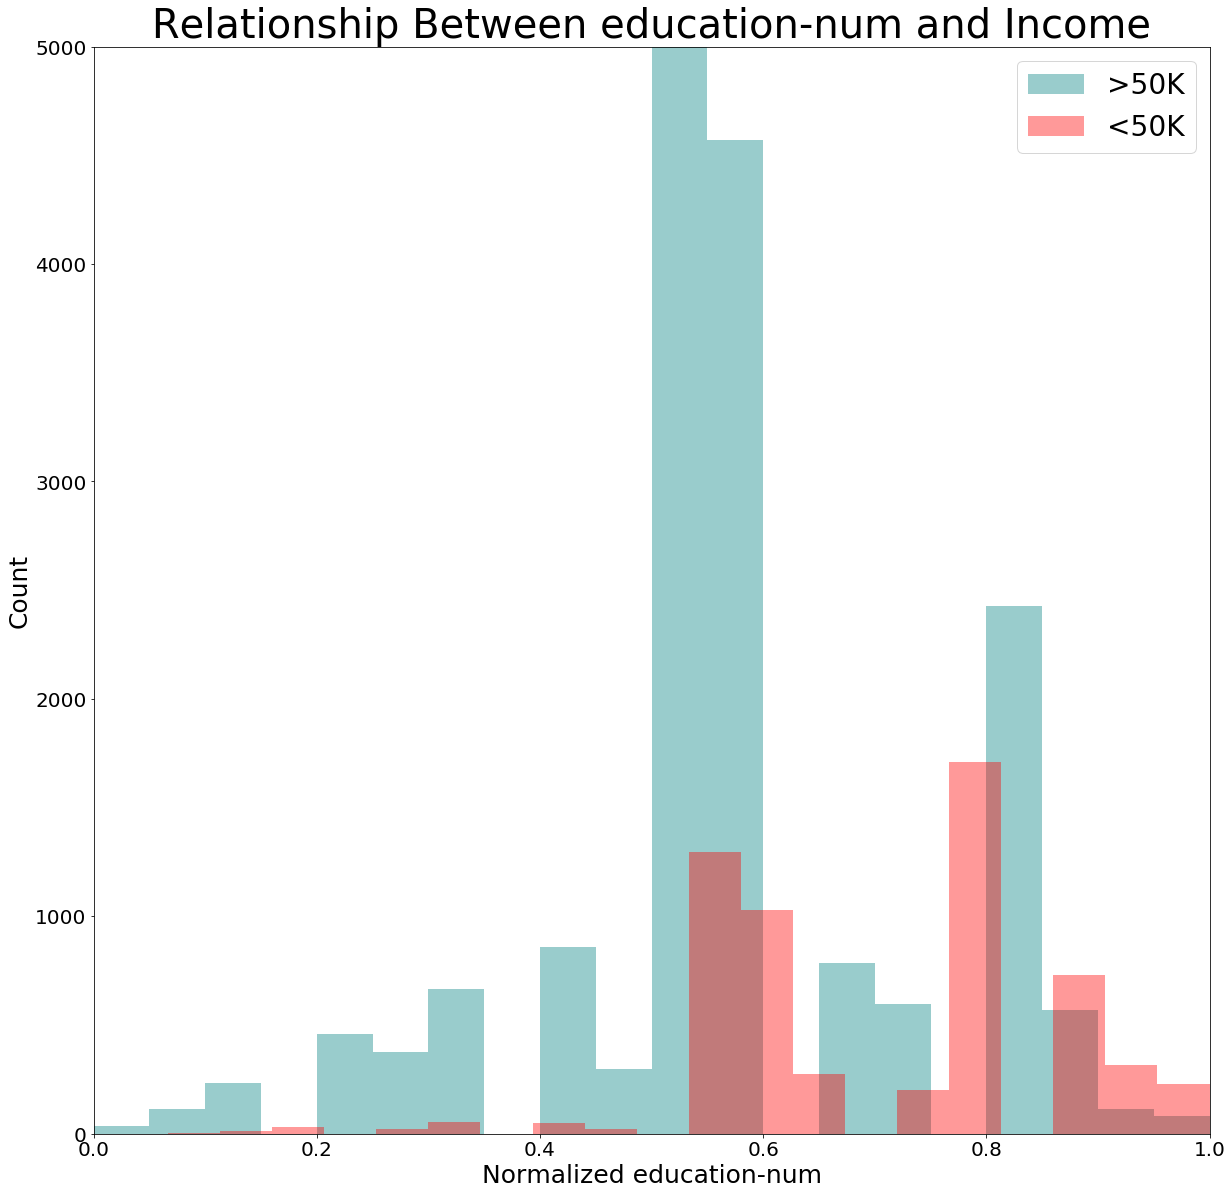

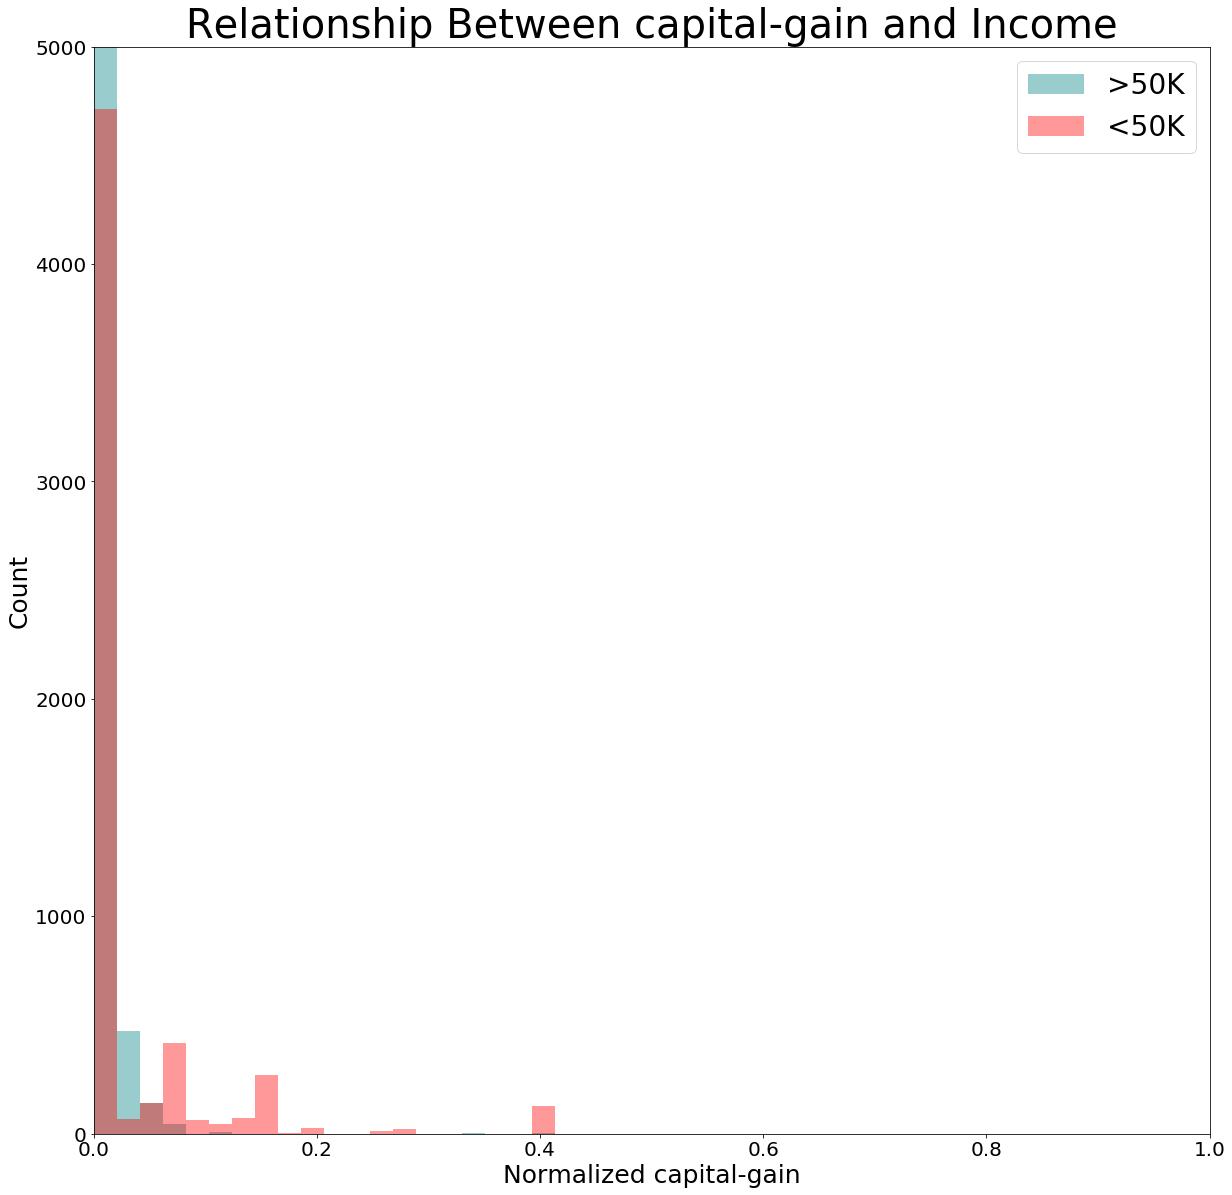

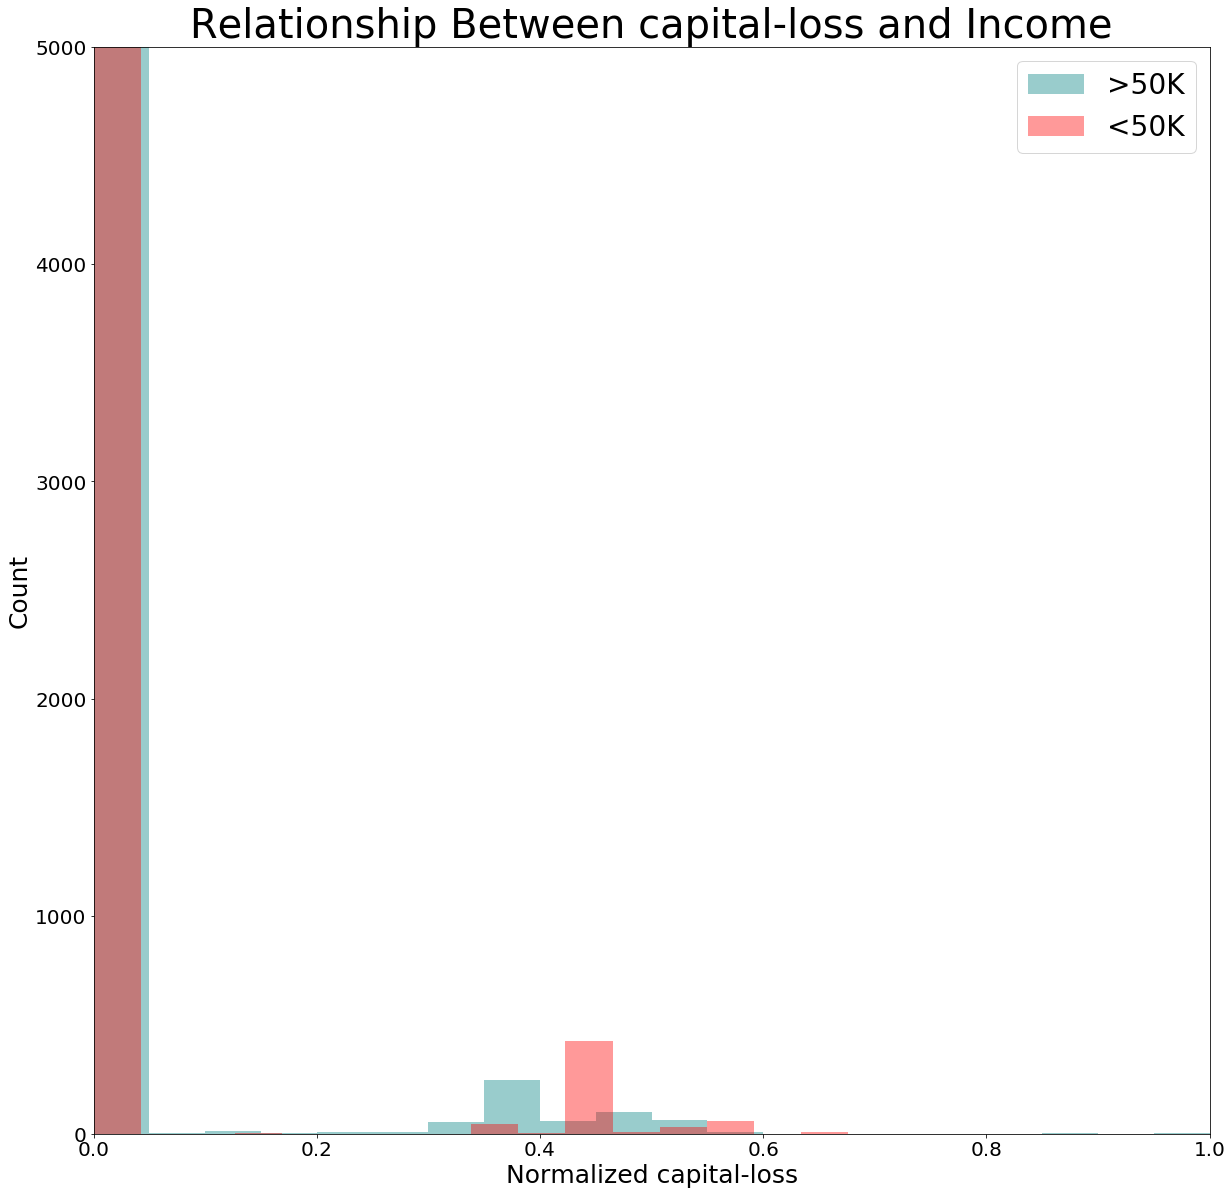

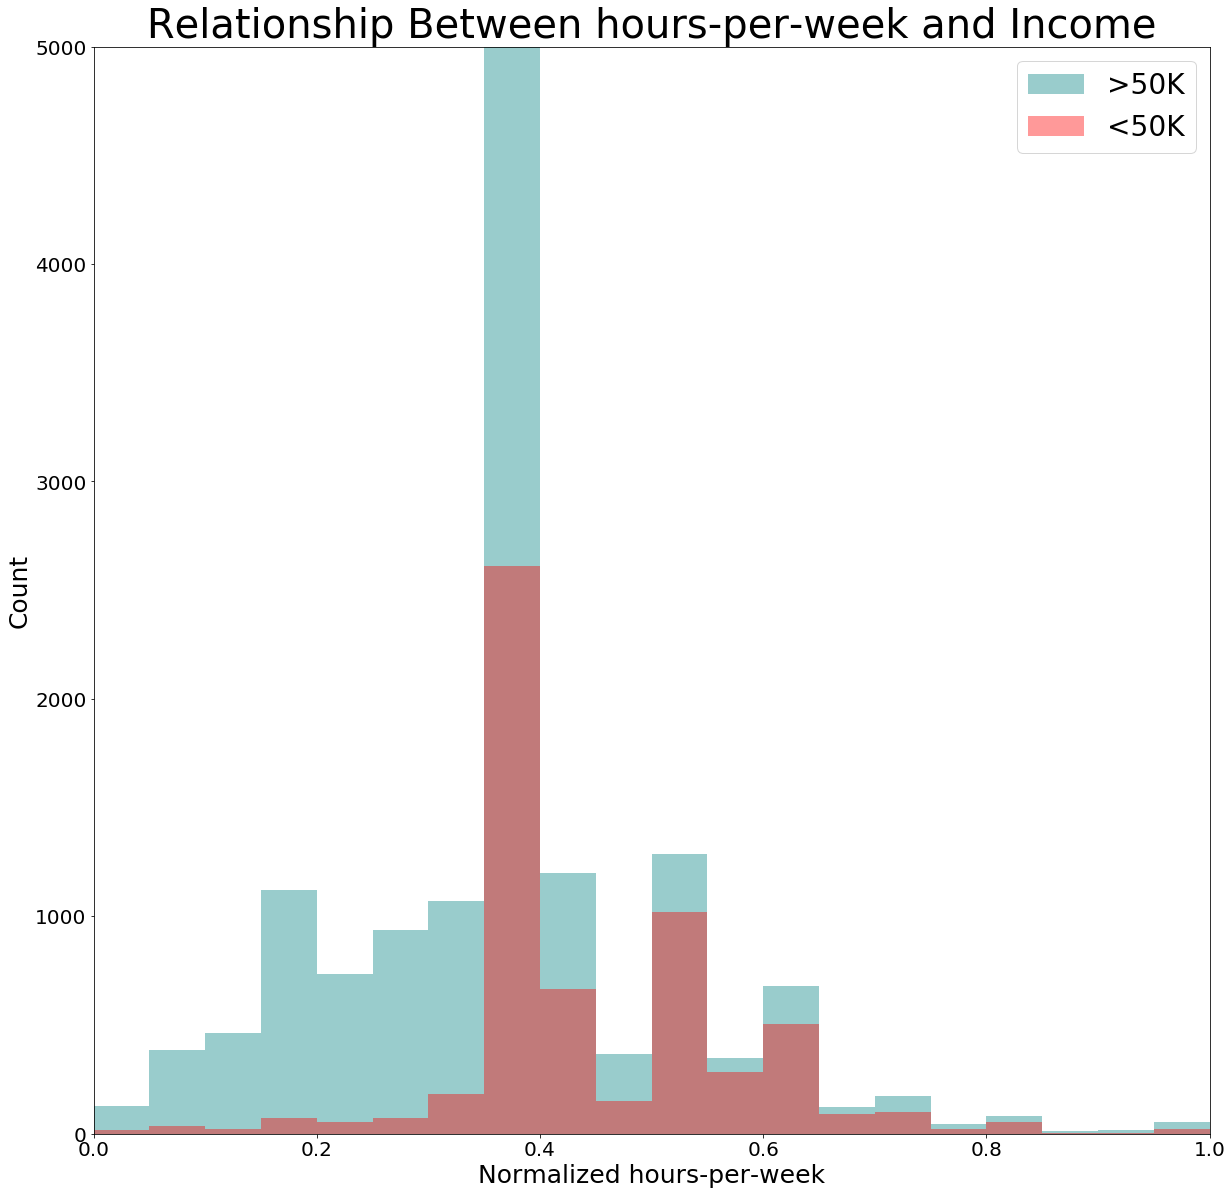

In [3]:
##Do EDA for parts (e) and (f)
eda = full_train.copy()
##Find numerical predictors
numerical_predictors = [col for col in eda if eda[col].dtype == 'int64' and col != target]
## Find categorical predictors
categorical_predictors = [col for col in eda.columns if col != target and col not in numerical_predictors]

##Find numerical predictors
numerical_predictors = [col for col in eda if eda[col].dtype == 'int64' and col != target]
## Find categorical predictors
categorical_predictors = [col for col in eda.columns if col != target and col not in numerical_predictors]
## Process numerical variables
scaler = preprocessing.MinMaxScaler()
eda[numerical_predictors] = scaler.fit_transform(eda[numerical_predictors])


bins = [0, 20, 30, 40, 50, 60, 1000]
names = ['<20', '20-30', '30-40', '40-50', '50-60', '60+']
eda['AgeRange'] = pd.cut(eda['age'], bins, labels=names)

## Process Capital Gain

max_val = max(eda["capital-gain"])
eda.loc[eda["capital-gain"] == max_val, "capital-gain"] = -1
max_val = max(eda["capital-gain"])
eda.loc[eda["capital-gain"] == -1, "capital-gain"] = max_val

## Graphs for categorical variables
for i in range(len(categorical_predictors)):
    plt.figure(figsize = (20,20))
    plt.title("Relationship Between " + str(categorical_predictors[i]) + " and Income", fontsize = 40)
    plt.xticks(rotation = 45)
    sns.countplot(categorical_predictors[i],hue='income',data = eda)
    plt.legend(bbox_to_anchor=(0.8, 0.9), loc='upper left', borderaxespad=0.)

## Graphs for numerical variables
above_50K = eda[eda[target]=="<=50K."]
below_50K = eda[eda[target]==">50K."]

for i in range(len(numerical_predictors)):
    plt.figure(figsize = (20,20))
    plt.title("Relationship Between " + str(numerical_predictors[i]) + " and Income", fontsize = 40)
    plt.hist(above_50K[numerical_predictors[i]], bins=20, color = 'teal', alpha=.4, label = '>50K')
    plt.hist(below_50K[numerical_predictors[i]], bins=20, color = 'red', alpha=.4, label = '<50K')
    plt.legend(loc='upper right')
    plt.axis([0,1,0,5000])
    plt.xlabel("Normalized " + str(numerical_predictors[i]),fontsize = 25)
    plt.ylabel("Count",fontsize = 25)
    plt.show()

## Define Data Prep Functions

In [4]:
def prepare_data(clean, target, bin_data=True):
    """
    clean: DataFrame
    target:String, name of Target
    return: cleaned dataset
    """
    ##Find numerical predictors
    numerical_predictors = [col for col in clean if clean[col].dtype == 'int64' and col != target]
    
    ## Find categorical predictors
    categorical_predictors = [col for col in clean.columns if col != target and col not in numerical_predictors]
    
    ## Create dummies for target
    if target:
        clean[target] = [0 if x == "<=50K." else 1 for x in clean[target]]
    
    ## Bin categorical variables to reduce dimensionality
    if bin_data:
        clean_workclass(clean)
        clean_education(clean)
        clean_occupation(clean)
        clean_marital(clean)
        clean_capital_gains(clean)
        
    ##Always bin this to avoid error on unseen country
    clean_native_country(clean)
    ##Get Dummies
    clean = pd.get_dummies(clean, columns = categorical_predictors)
    
    ##Use min-max scaling to scale numerical predictors
    scale_numeric(clean, numerical_predictors)
    return(clean)

def clean_capital_gains(cleaned_train):
    """
    cleaned_train: DataFrame
    There are many 99,999 in the dataset, replace with next highest capital gain
    """
    max_val = max(cleaned_train["capital-gain"])
    cleaned_train.loc[cleaned_train["capital-gain"] == max_val, "capital-gain"] = -1
    max_val = max(cleaned_train["capital-gain"])
    cleaned_train.loc[cleaned_train["capital-gain"] == -1, "capital-gain"] = max_val

    
def clean_workclass(cleaned_train):
    """
    cleaned_train: DataFrame
    """
    ##Clean workclass by binning down into categories
    self_employed = ["Self-emp-not-inc", "Self-emp-inc"]
    government = ["Local-gov", "State-gov", "Federal-gov"]
    other = ["?", "Without-pay", "Never-worked"]
    
    for i in range(len(cleaned_train["workclass"])):
        val = cleaned_train["workclass"][i]
        if val in self_employed:
            cleaned_train["workclass"][i] = "self_employed"
        elif val in government:
            cleaned_train["workclass"][i] = "government"
        elif val in other:
            cleaned_train["workclass"][i] = "other"
        else:
            cleaned_train["workclass"][i] = "other"
        
def clean_education(cleaned_train):
    """
    cleaned_train: DataFrame
    """
    ##Clean education by binning down into categories
    advanced_degree = ["Masters","Doctorate"]
    high_school = ["9th","10th","11th", "12th"]
    no_high_school = ["Preschool","1st-4th","5th-6th", "7th-8th"]
    associates_prof = ["Assoc-voc", "Assoc-acdm", "Prof-school"]
    
    for i in range(len(cleaned_train["education"])):
        val = cleaned_train["education"][i]
        if val in advanced_degree:
            cleaned_train["education"][i] = "advanced_degree"
        elif val in high_school:
            cleaned_train["education"][i] = "high_school"
        elif val in no_high_school:
            cleaned_train["education"][i] = "no_high_school"
        elif val in associates_prof:
            cleaned_train["education"][i] = "associates_prof"

def clean_occupation(cleaned_train):
    """
    cleaned_train: DataFrame
    """
    ##Clean occupation by binning down into categories
    other = ["?","Armed-Forces","Other", "Other-service"] ##Only 7 records in armed forces so safe to lump into other
    serv = ["Protective-serv", "Priv-house-serv"]
    
    for i in range(len(cleaned_train["occupation"])):
        val = cleaned_train["occupation"][i]
        if val in other:
            cleaned_train["occupation"][i] = "Other"
        elif val in serv:
            cleaned_train["occupation"][i] = "Serv"
        else:
            cleaned_train["occupation"][i] = "Other"

def clean_marital(cleaned_train):
    """
    cleaned_train: DataFrame
    """
    ##Clean marital status by binning down into categories
    married = ["Married-civ-spouse", "Married-AF-spouse"]
    sep_divorced_absent = ["Divorced", "Separated", "Married-spouse-absent"]
    
    for i in range(len(cleaned_train["marital-status"])):
        val = cleaned_train["marital-status"][i]
        if val in married:
            cleaned_train["marital-status"][i] = "married"
        elif val in sep_divorced_absent:
            cleaned_train["marital-status"][i] = "sep_divorced_absent"

def clean_native_country(cleaned_train):
    """
    cleaned_train: DataFrame
    """
    ##Clean native-country by binning down into categories
    for i in range(len(cleaned_train["native-country"])):
        val = cleaned_train["native-country"][i]
        if val != "United-States":
            cleaned_train["native-country"][i] = "not_US"

def scale_numeric(cleaned_train, numerical_predictors):
    """
    cleaned_train: DataFrame
    numerical_predictors: List of Strings; each string is a predictor name
    """
    ##Create scaler
    scaler = preprocessing.MinMaxScaler()
    
    ##Fit and transform numerical columns
    cleaned_train[numerical_predictors] = scaler.fit_transform(cleaned_train[numerical_predictors])

## Clean Data

In [5]:
## copy to not affect initial data
cleaned_train = full_train.copy()

## Run method to bin categorical data and scale numeric data
cleaned_train = prepare_data(cleaned_train, target)
cleaned_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 25000 non-null  float64
 1   demogweight                         25000 non-null  float64
 2   education-num                       25000 non-null  float64
 3   capital-gain                        25000 non-null  float64
 4   capital-loss                        25000 non-null  float64
 5   hours-per-week                      25000 non-null  float64
 6   income                              25000 non-null  int64  
 7   workclass_government                25000 non-null  uint8  
 8   workclass_other                     25000 non-null  uint8  
 9   workclass_self_employed             25000 non-null  uint8  
 10  education_Bachelors                 25000 non-null  uint8  
 11  education_HS-grad                   25000

# Make Predictions with Neural Network

## Define Function to get Important Features

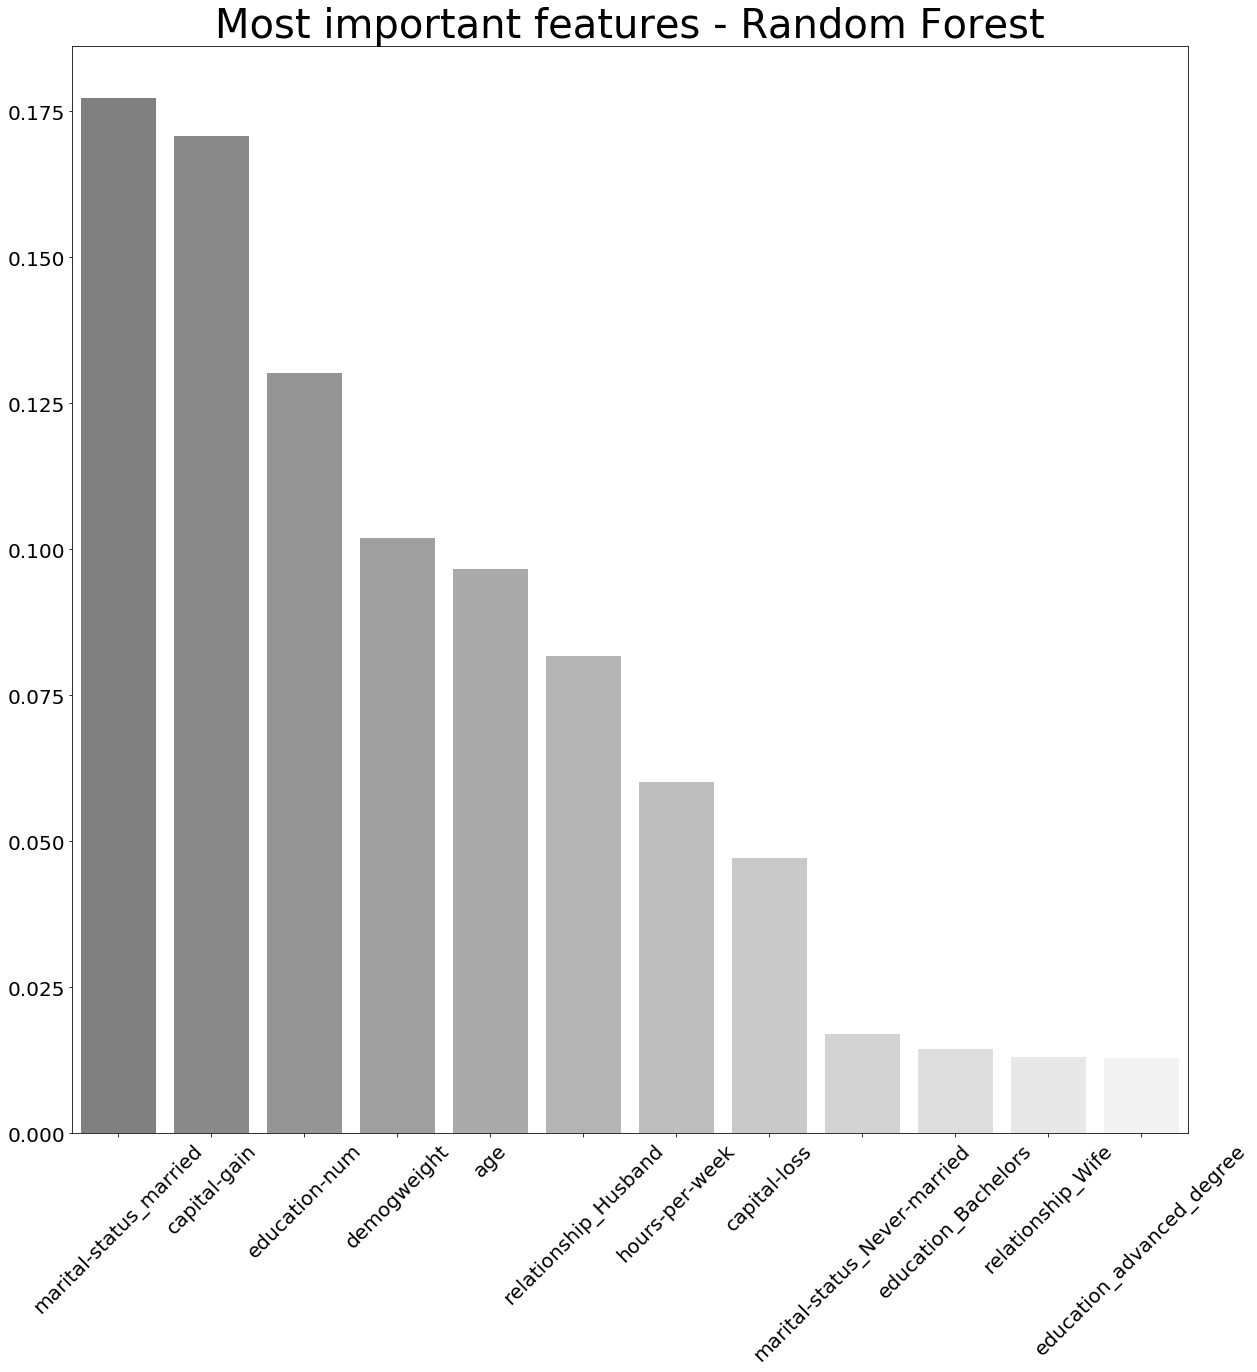

In [6]:
##Get all predictors
predictors = [col for col in cleaned_train if col != target]

##Get the number of predictors
num_predictors = len(predictors)
num_top_predictors = 16

##Get the top predictors using Random Forest Classifier to experiment with neural models that only train on top predictors
rfc = RandomForestClassifier(n_estimators = 500, random_state = 4, min_samples_split = 25, max_features = 15)
rfc.fit(cleaned_train[predictors], cleaned_train[target])

##Get sorted list of feature importances from Random Forest
rfc_feature_names = [x for _,x in sorted(zip(rfc.feature_importances_,predictors))][::-1]
rfc_importances = sorted(rfc.feature_importances_)[::-1]

plt.figure(figsize=(20,20))
plt.title("Most important features - Random Forest", fontsize=40)
plt.xticks(rotation=45)
sns.barplot(rfc_feature_names[:12], rfc_importances[:12], palette=sns.light_palette("gray",12, reverse=True))
    
    
## Get list of top predictors according to RandomForest
top_predictors = rfc_feature_names[:num_top_predictors]


## Define Neural Nets Models Structure

In [7]:
def shallow_NN(input_dim=None, optimizer="Nadam"):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

def deep_NN(input_dim=None, optimizer="Nadam"):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation="relu"))
    model.add(Dense(16, input_dim=input_dim, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

def deep_NN_dropout(input_dim=None, optimizer="Nadam"):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(16, input_dim=input_dim, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

## Define Neural Nets Classifier Models

In [8]:
##Build a variety of neural nets models to test (shallow, deep, with dropout)
shallow_all_preds = KerasClassifier(build_fn = shallow_NN, input_dim= len(predictors), batch_size = 32, epochs = 20)
shallow_top_preds = KerasClassifier(build_fn = shallow_NN, input_dim= len(top_predictors), batch_size = 32, epochs = 20)

deep_all_preds = KerasClassifier(build_fn = deep_NN, input_dim= len(predictors), batch_size = 32, epochs = 20)
deep_top_preds = KerasClassifier(build_fn = deep_NN, input_dim= len(top_predictors), batch_size = 32, epochs = 20)

deep_all_preds_dropout = KerasClassifier(build_fn = deep_NN_dropout, input_dim= len(predictors), batch_size = 32, epochs = 40)
deep_top_preds_dropout = KerasClassifier(build_fn = deep_NN_dropout, input_dim= len(top_predictors), batch_size = 32, epochs = 40)

## Create List of Models to Loop Through

In [9]:
## Order and specify names for models
NN_models_all_preds = [shallow_all_preds, deep_all_preds,  deep_all_preds_dropout]
names_all = ["Shallow - All Predictors", "Deep - All Predictors", "Deep w/Drop Out - All Predictors"]

NN_models_top_preds = [shallow_top_preds, deep_top_preds, deep_top_preds_dropout]
names_top = ["Shallow - Top Predictors", "Deep - Top Predictors", "Deep w/Drop Out - Top Predictors"]

### Initiate List to Store Fitted Models

In [10]:
fitted_models = []

## Fit All Models

In [11]:
for i in range(len(NN_models_all_preds)):
    ##Fit model to all data
    fitted_models.append(NN_models_all_preds[i].fit(cleaned_train[predictors], cleaned_train[target], validation_split=0.3, verbose =0))
    ## Plot train and validation accuracy accuracy
   
for i in range(len(NN_models_top_preds)):
    ##Fit model to top predictor data
    fitted_models.append(NN_models_top_preds[i].fit(cleaned_train[top_predictors], cleaned_train[target], validation_split=0.3, verbose = 0))

## Plot Training and Validation Accuracy to Find Best Model

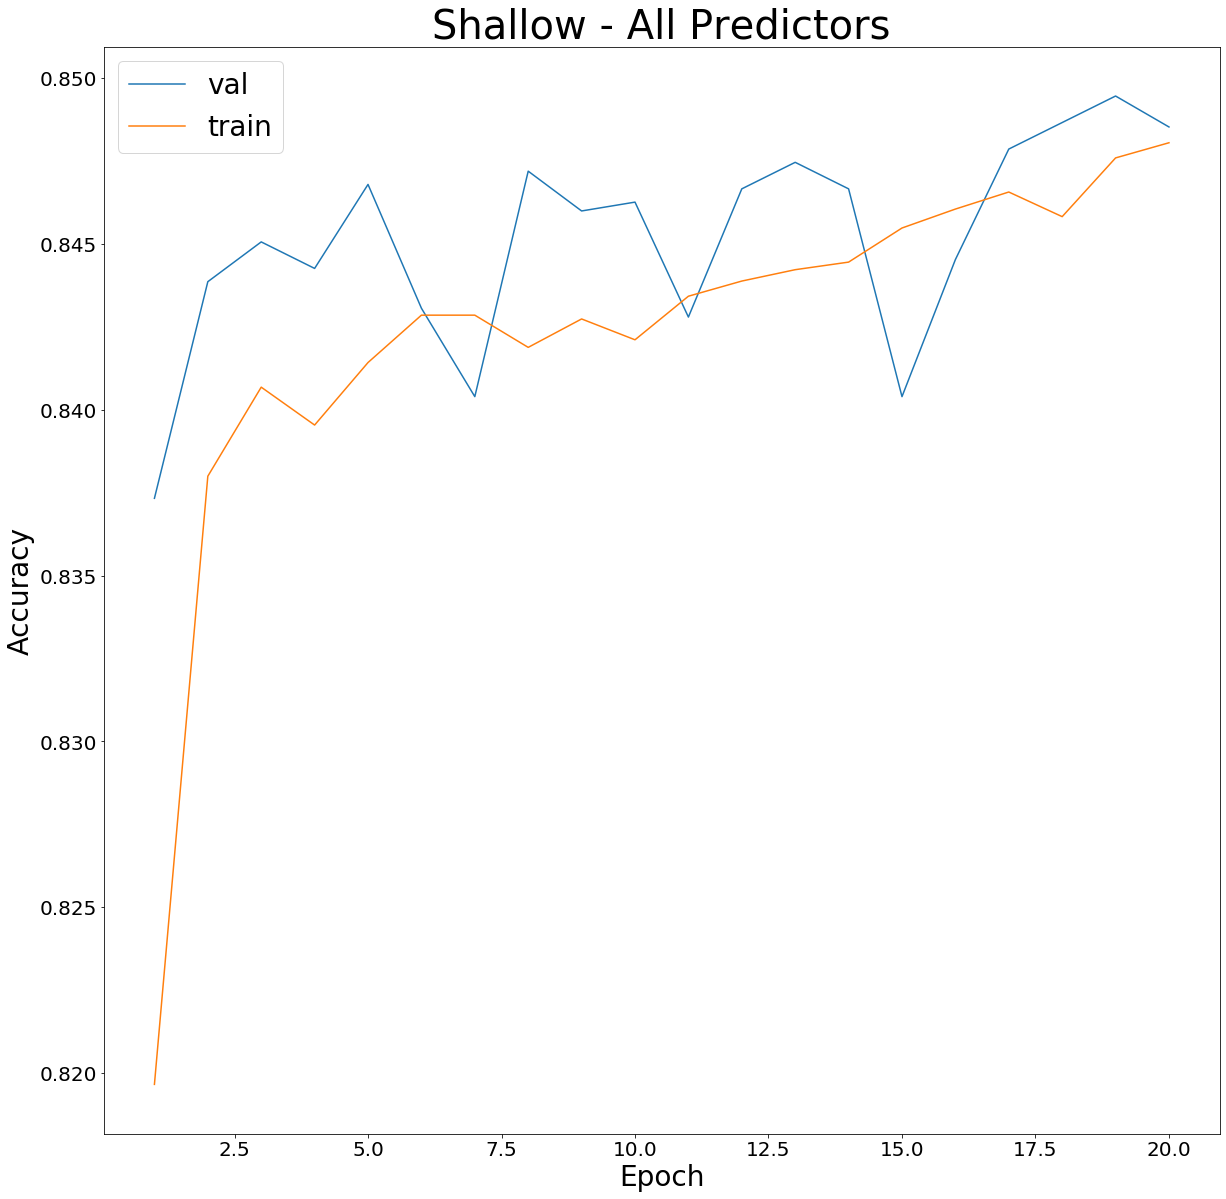

Max Validation Accuracy: 0.8494666814804077


<Figure size 432x288 with 0 Axes>

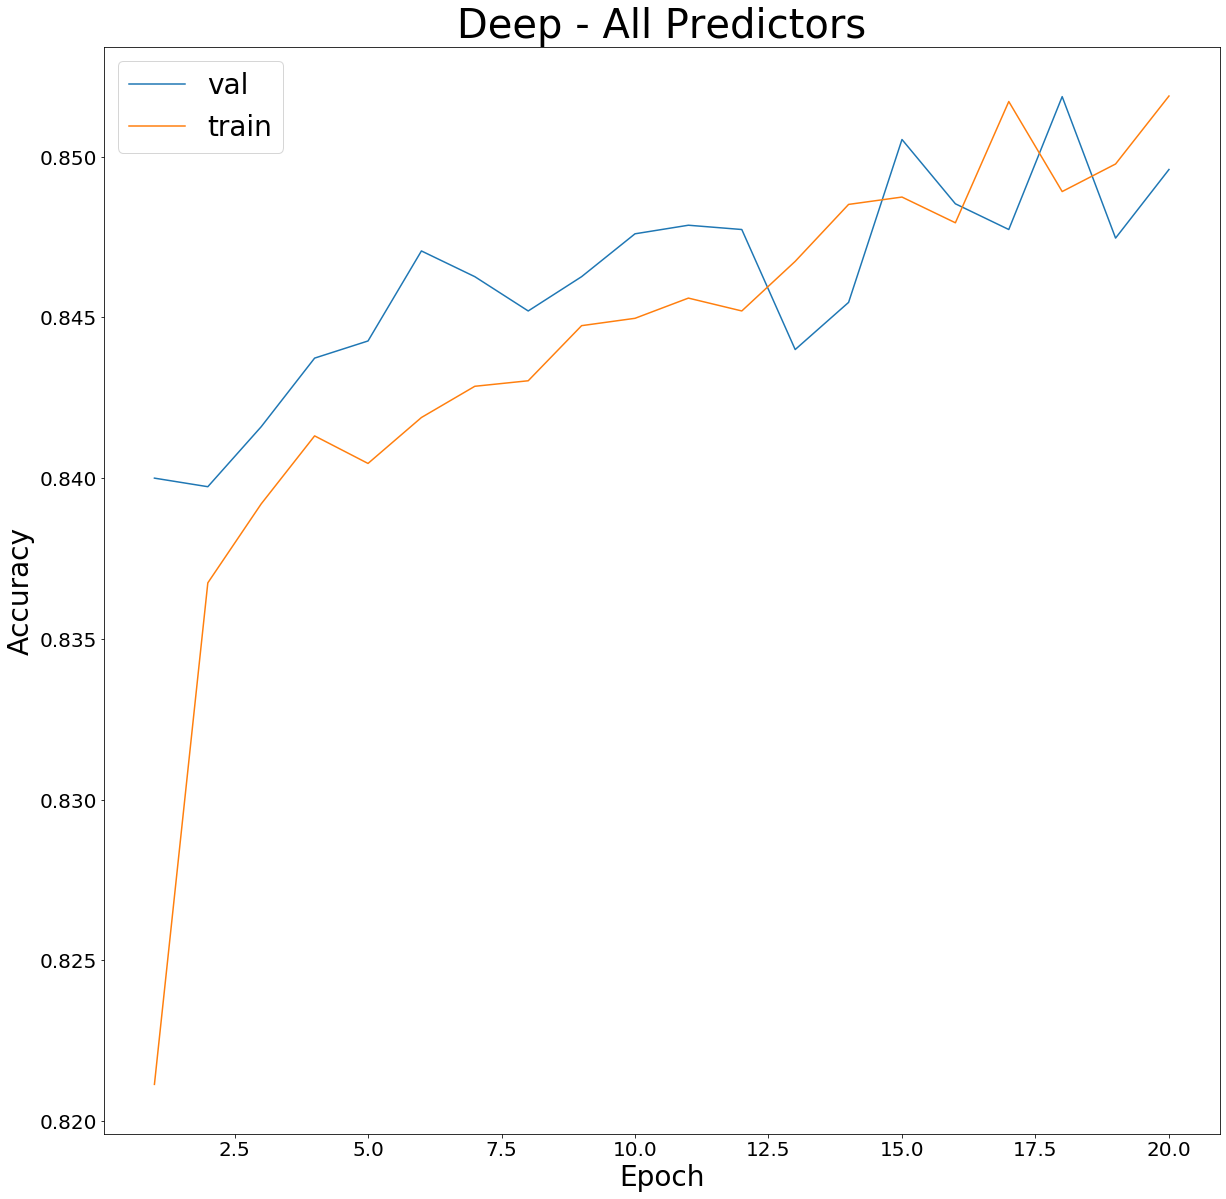

Max Validation Accuracy: 0.8518666625022888


<Figure size 432x288 with 0 Axes>

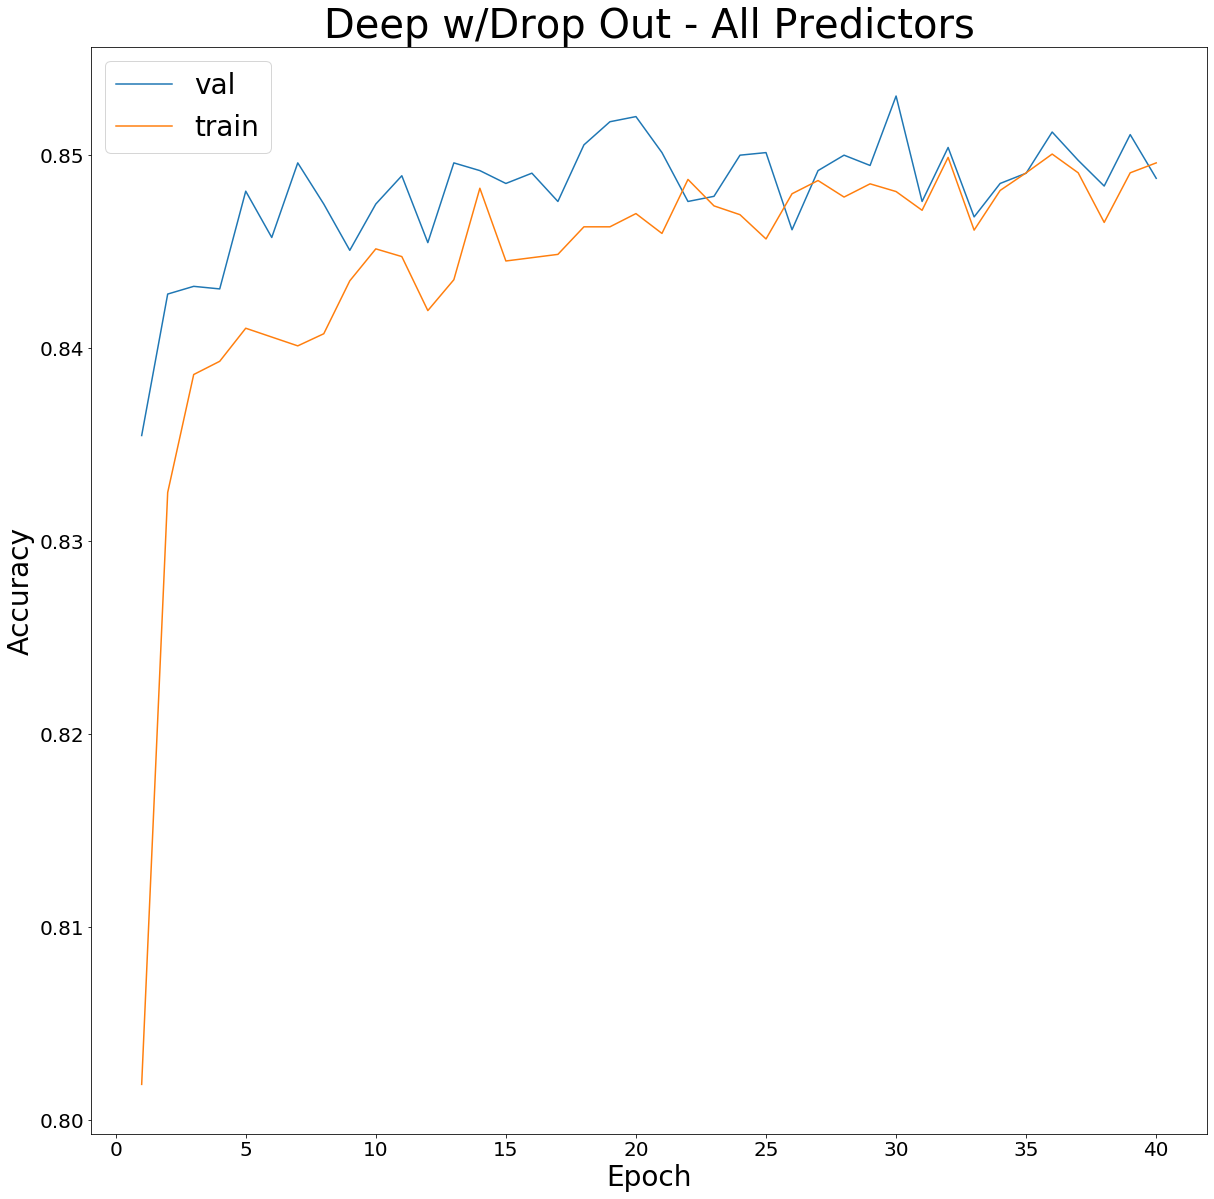

Max Validation Accuracy: 0.8530666828155518


<Figure size 432x288 with 0 Axes>

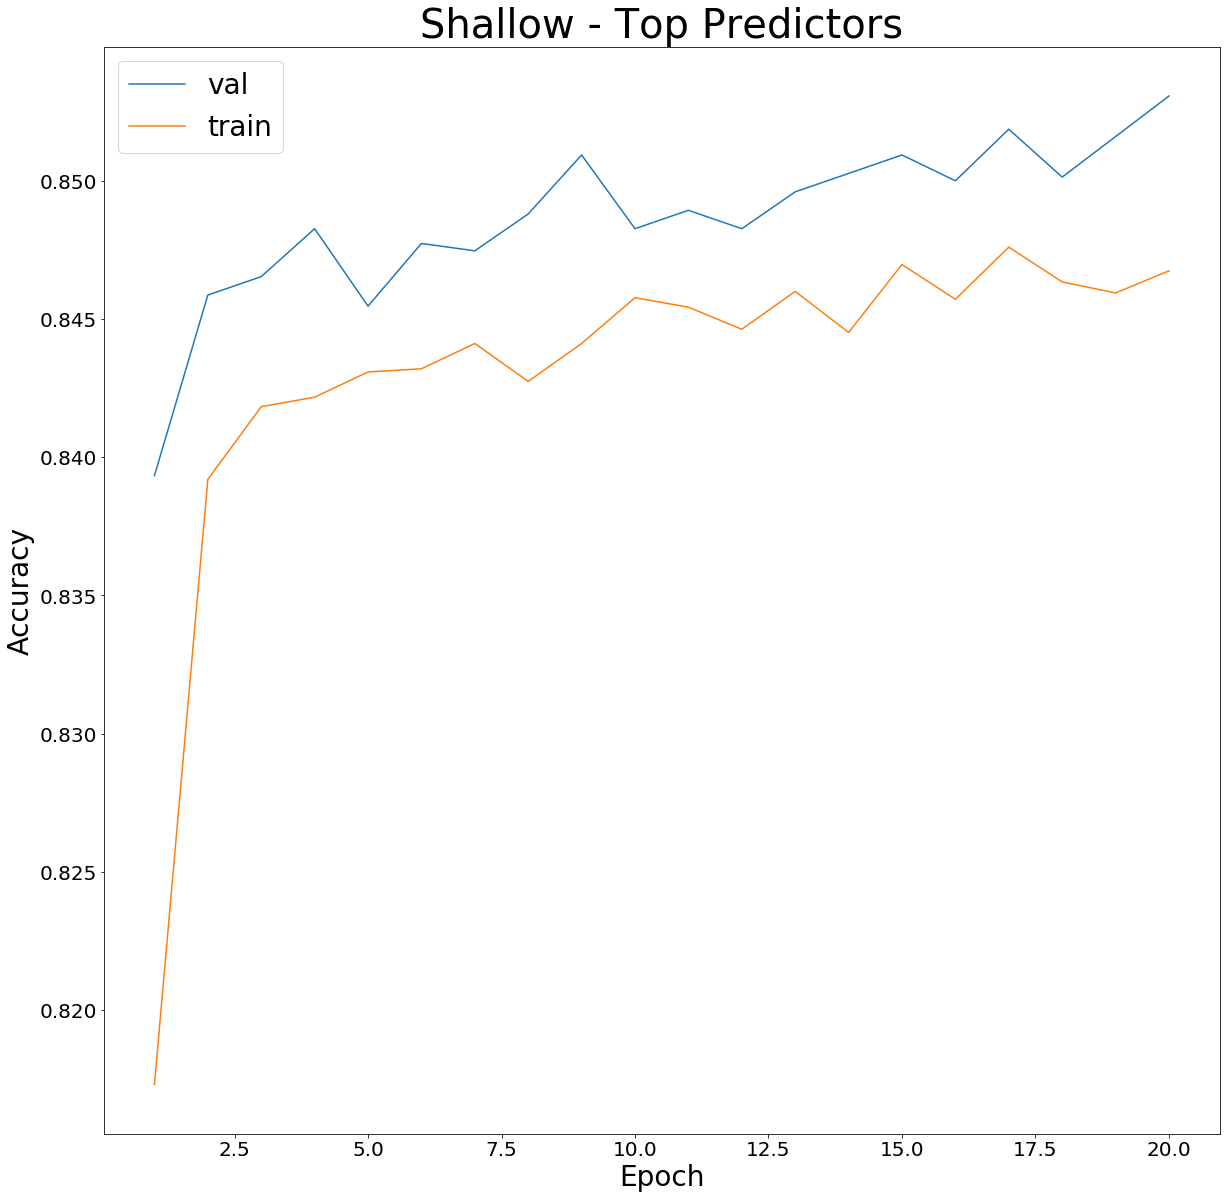

Max Validation Accuracy: 0.8530666828155518


<Figure size 432x288 with 0 Axes>

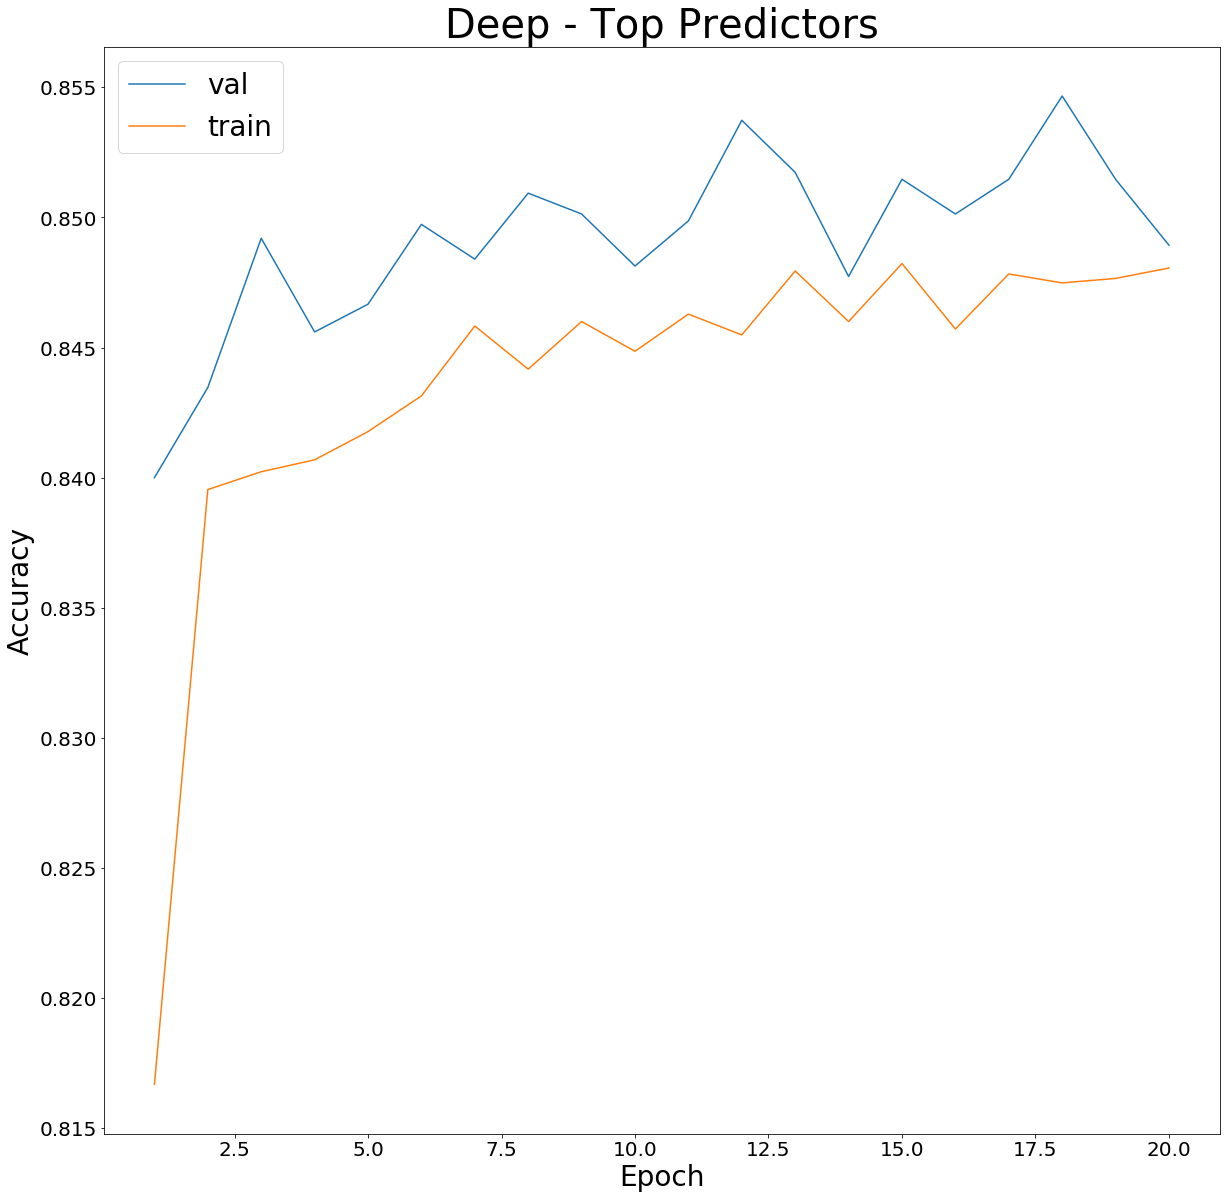

Max Validation Accuracy: 0.8546666502952576


<Figure size 432x288 with 0 Axes>

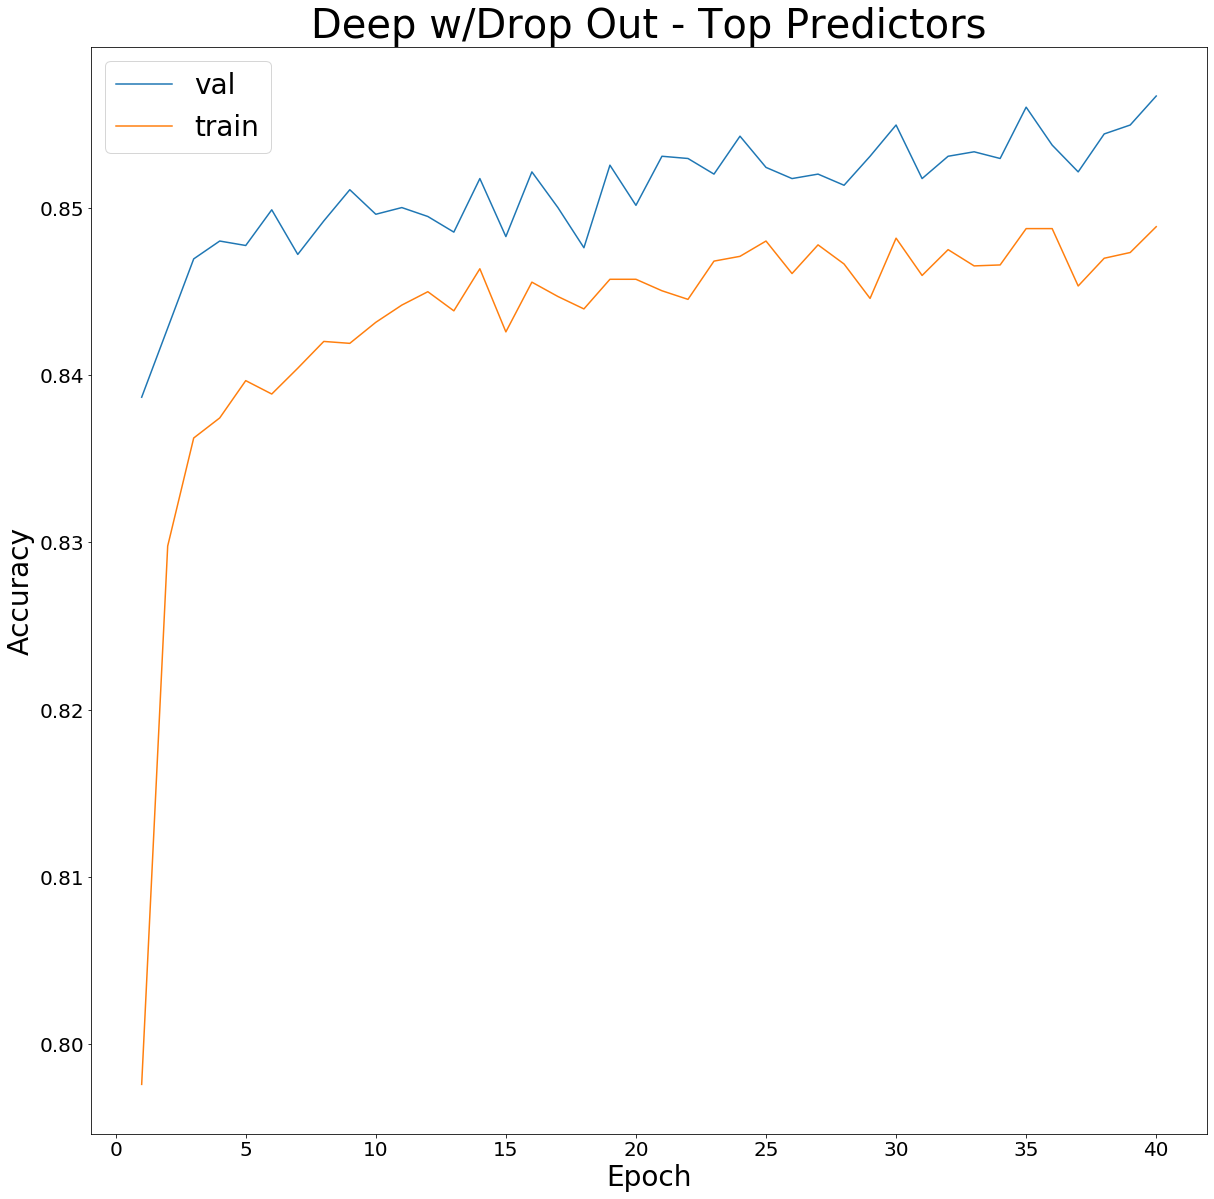

Max Validation Accuracy: 0.8566666841506958


<Figure size 432x288 with 0 Axes>

In [12]:
names = names_all + names_top

for i in range(len(fitted_models)):
   ## Plot train and validation accuracy
    plt.figure(figsize=(20,20))
    plt.title(names[i], fontsize=40)
    epoch_names = [i for i in range(1, len(fitted_models[i].history["val_accuracy"])+1)]
    plt.plot(epoch_names, fitted_models[i].history["val_accuracy"], label="val")
    plt.plot(epoch_names, fitted_models[i].history["accuracy"], label="train")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    plt.clf()
    print("Max Validation Accuracy: " + str(max(fitted_models[i].history["val_accuracy"])))

Why is the training accuracy constantly higher than validation accuracy?

--for models with drop-out, this is understandable.

--but for models without drop-out?

## Define a Function to Find Important Features

In [13]:
def get_importances(model, cleaned_train, predictors):
    ##Get feature importances for neural network using Permuation Importance
    perm = PermutationImportance(model, random_state=1, n_iter=5).fit(cleaned_train[predictors], cleaned_train[target])
    
    ##Sort feature names by their importance
    names = [x for _,x in sorted(zip(perm.feature_importances_,predictors))]
    values = sorted(perm.feature_importances_)
    
    ##plot on bar plots for most and least important
    plt.figure(figsize=(20,20))
    plt.title("Most important features", fontsize=40)
    plt.ylabel("Importance")
    ax=sns.barplot(names[::-1][:12], values[::-1][:12], palette=sns.light_palette("blue",12, reverse=True))
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
        )
    plt.figure(figsize=(20,20))
    plt.title("Least important features", fontsize=40)
    plt.ylabel("Importance")
    ax=sns.barplot(names[:12], values[:12], palette=sns.light_palette("red",12, reverse = False))
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
        )
    return names, values

25000/25000 [==============================] - 1s 42us/step


25000/25000 [==============================] - 1s 43us/step


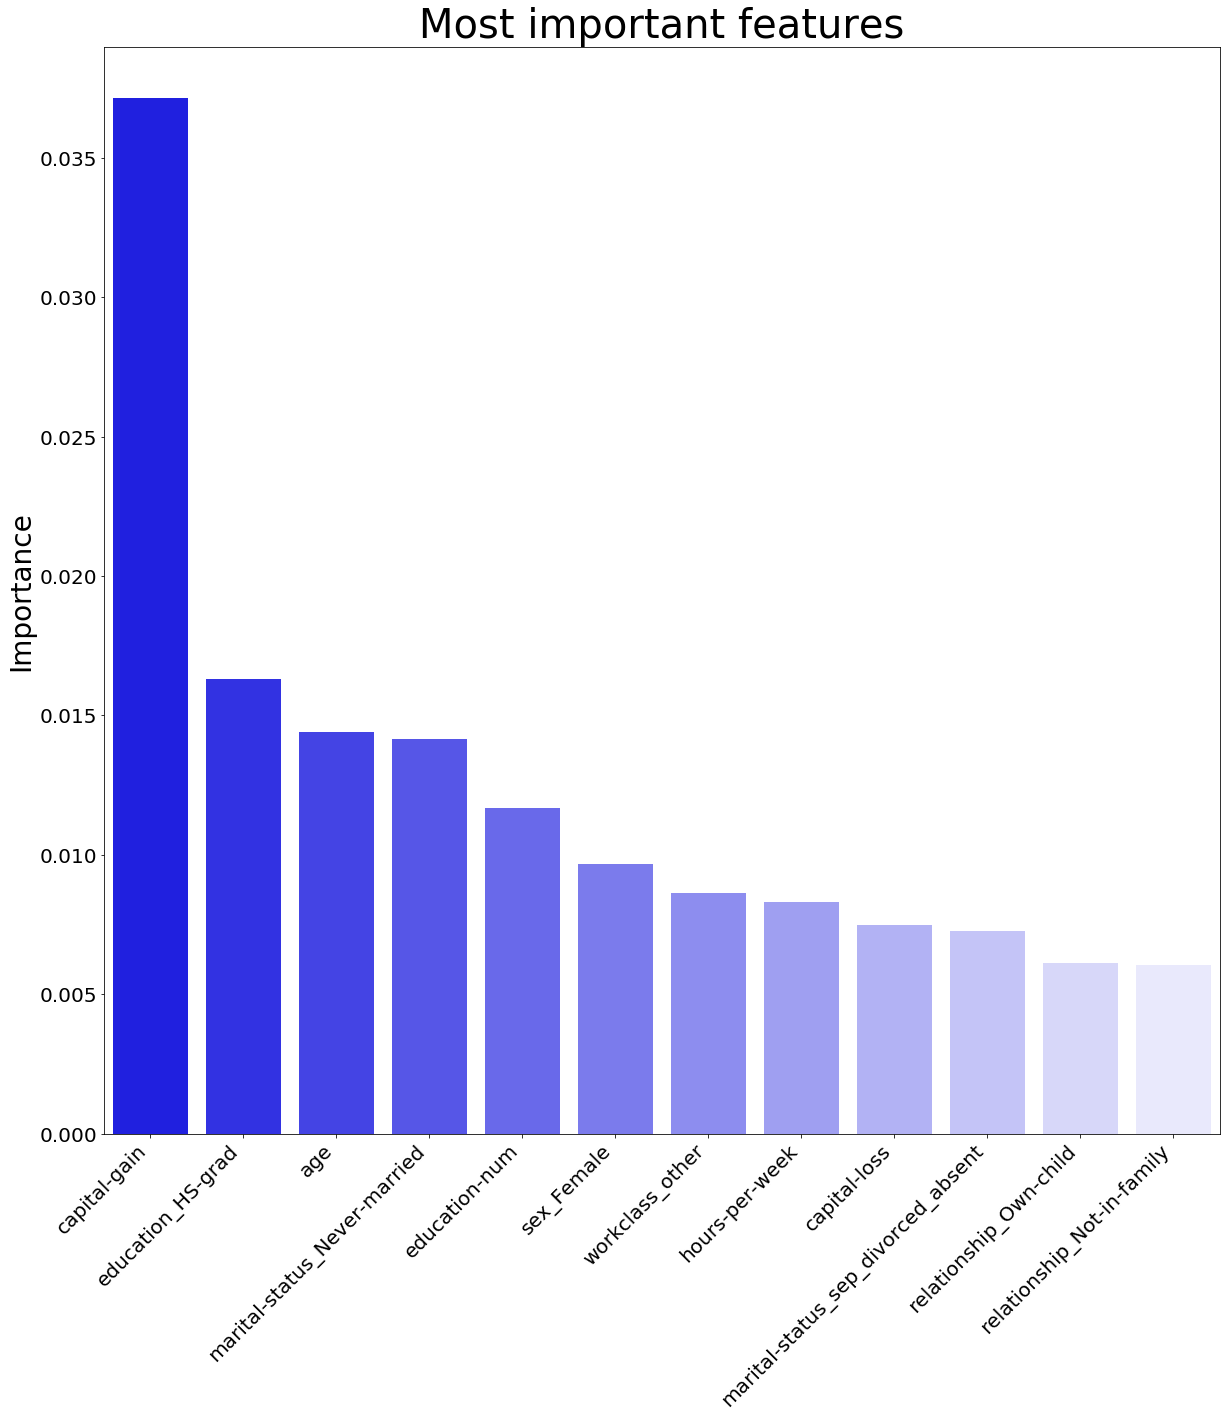

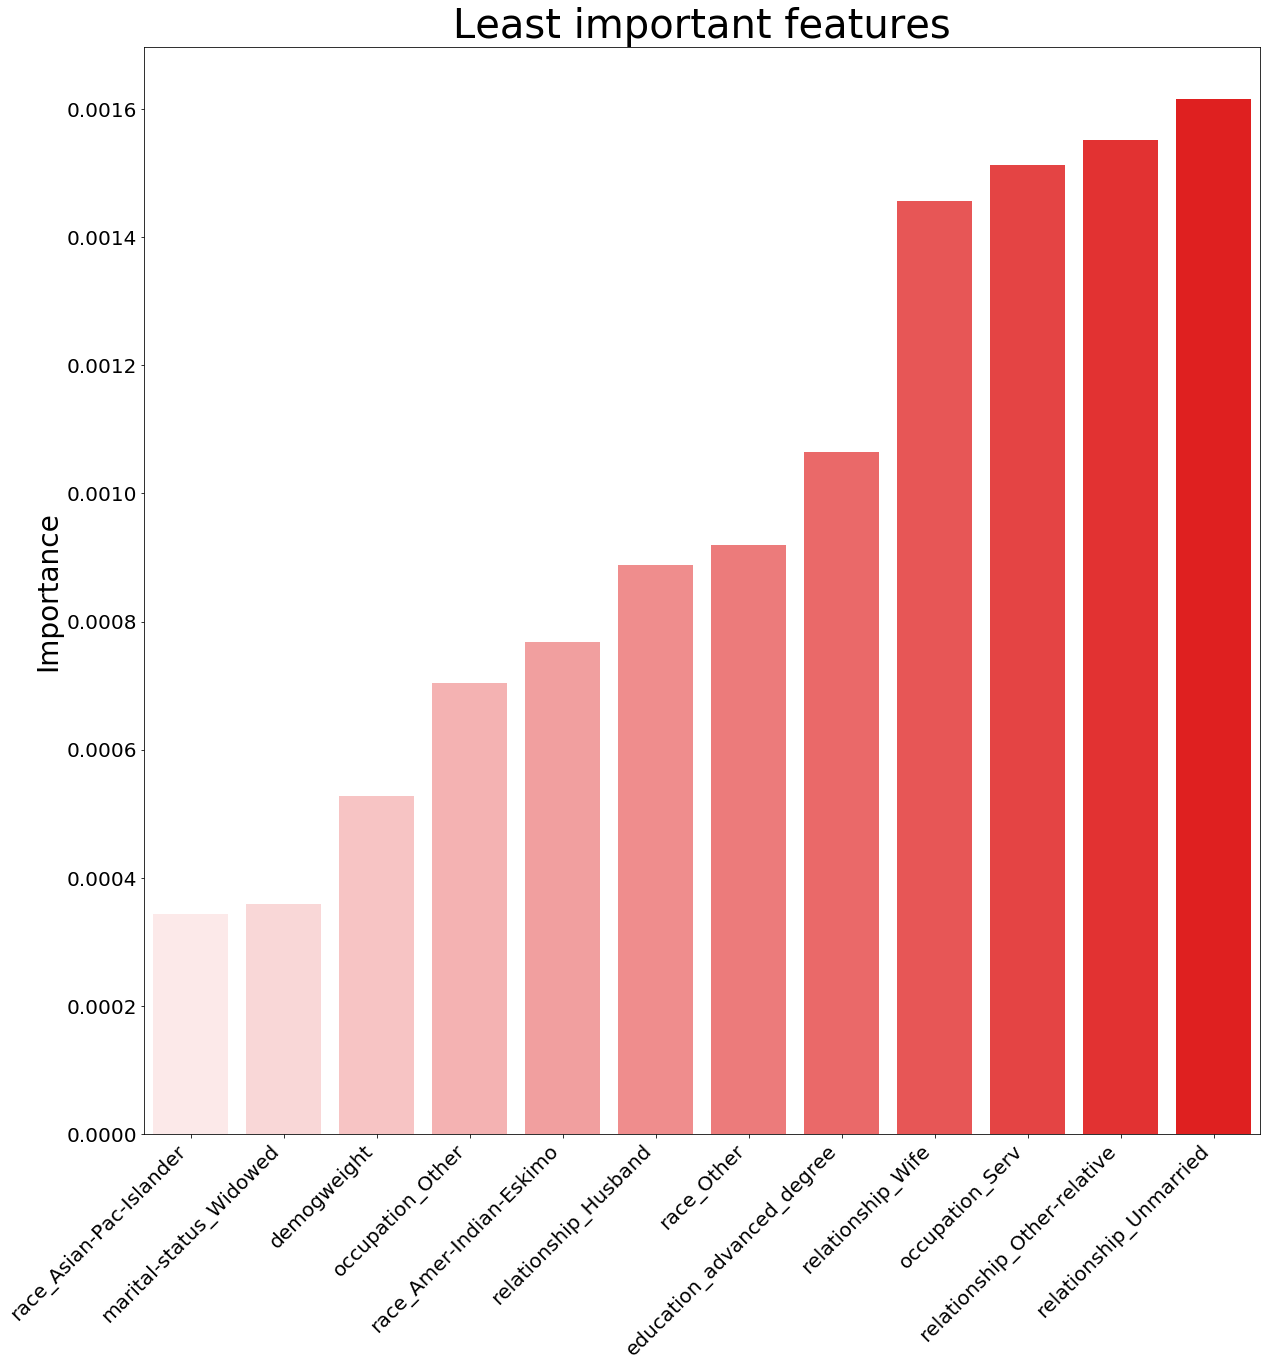

In [14]:
##See which features are important
names, values = get_importances(deep_all_preds_dropout, cleaned_train, predictors)

## Train Best Model with Optimal Epoch

Although all models perform similar, Deep NN with all predictors performed slightly better

Train again with optimal model and epoch

In [15]:
deep_all_preds_dropout = KerasClassifier(build_fn = deep_NN_dropout, input_dim= len(predictors), batch_size = 32, epochs = 36)
deep_all_preds_dropout.fit(cleaned_train[predictors], cleaned_train[target], verbose = 2)

Epoch 1/36
 - 3s - loss: 0.3860 - accuracy: 0.8161
Epoch 2/36
 - 2s - loss: 0.3479 - accuracy: 0.8375
Epoch 3/36
 - 2s - loss: 0.3429 - accuracy: 0.8398
Epoch 4/36
 - 2s - loss: 0.3392 - accuracy: 0.8411
Epoch 5/36
 - 2s - loss: 0.3359 - accuracy: 0.8438
Epoch 6/36
 - 2s - loss: 0.3334 - accuracy: 0.8454
Epoch 7/36
 - 2s - loss: 0.3314 - accuracy: 0.8448
Epoch 8/36
 - 2s - loss: 0.3314 - accuracy: 0.8468
Epoch 9/36
 - 2s - loss: 0.3280 - accuracy: 0.8461
Epoch 10/36
 - 2s - loss: 0.3273 - accuracy: 0.8470
Epoch 11/36
 - 2s - loss: 0.3252 - accuracy: 0.8468
Epoch 12/36
 - 2s - loss: 0.3251 - accuracy: 0.8473
Epoch 13/36
 - 2s - loss: 0.3258 - accuracy: 0.8468
Epoch 14/36
 - 2s - loss: 0.3254 - accuracy: 0.8472
Epoch 15/36
 - 2s - loss: 0.3234 - accuracy: 0.8475
Epoch 16/36
 - 2s - loss: 0.3238 - accuracy: 0.8476
Epoch 17/36
 - 2s - loss: 0.3224 - accuracy: 0.8485
Epoch 18/36
 - 2s - loss: 0.3228 - accuracy: 0.8486
Epoch 19/36
 - 2s - loss: 0.3227 - accuracy: 0.8475
Epoch 20/36
 - 2s - l

## Test on Totally Separated Test Set

In [16]:
cleaned_test = prepare_data(full_test, target = target, bin_data=True)

In [17]:
##Get predictions
predictions = deep_all_preds_dropout.predict(cleaned_test[predictors])
print("Model Accuracy: " + str(accuracy_score(cleaned_test[target], predictions)))

Model Accuracy: 0.8411042134460441


In [18]:
##Get confusion matrix
confusion_matrix(cleaned_test[target], predictions)
print(classification_report(cleaned_test[target], predictions, target_names = ["Income <= 50K","Income >= 50K" ]))

               precision    recall  f1-score   support

Income <= 50K       0.86      0.95      0.90      5712
Income >= 50K       0.76      0.51      0.61      1859

     accuracy                           0.84      7571
    macro avg       0.81      0.73      0.76      7571
 weighted avg       0.83      0.84      0.83      7571



# Make Predictions with 11 Other Models and Re-Optimize Best ANN

## Re-Optimize Best ANN From Part 2

In [19]:
##Tune parameters for best ANN model
param_grid= {"epochs":[20, 40], "optimizer":['Adam','Nadam'], "batch_size":[25, 30]}
grid = GridSearchCV(estimator=deep_top_preds_dropout, param_grid=param_grid, cv=2)
grid.fit(cleaned_train[top_predictors], cleaned_train[target], verbose=100)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
12500/12500 [==============================] - 1s 54us/step
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
12500/12500 [==============================] - 1s 54us/step
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
12500/12500 [==============================] - 1s 54us/step
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoc

GridSearchCV(cv=2, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002E4DB2CBAC8>,
             iid='deprecated', n_jobs=None,
             param_grid={'batch_size': [25, 30], 'epochs': [20, 40],
                         'optimizer': ['Adam', 'Nadam']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Best Re-Optimized Model and Results

In [20]:
grid.best_params_
grid.best_score_
grid.cv_results_

{'mean_fit_time': array([27.39940751, 30.81657767, 53.60149837, 61.04653311, 23.19252288,
        25.52444637, 45.14135528, 50.8788209 ]),
 'std_fit_time': array([0.26436985, 0.09834266, 0.34370065, 0.21927142, 0.16848671,
        0.30732119, 0.71232653, 0.00909352]),
 'mean_score_time': array([0.72348869, 0.72273326, 0.75698125, 0.73366261, 0.6301266 ,
        0.64923012, 0.63447666, 0.63076913]),
 'std_score_time': array([0.00140536, 0.00531983, 0.00501668, 0.018327  , 0.00705397,
        0.0134207 , 0.00182223, 0.00244892]),
 'param_batch_size': masked_array(data=[25, 25, 25, 25, 30, 30, 30, 30],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[20, 20, 40, 40, 20, 20, 40, 40],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_optimizer': masked_array(data=['Adam', 'Nadam', 'Adam', 'N

Results are that Nadam, with 40 epochs and batch size 30 is the best

## Set up Other 11 Classifiers

In [21]:
#Random forest classifier
rfc = RandomForestClassifier(n_estimators = 700, random_state = 4, min_samples_split = 25, max_features = 15)

##Best neural model
final_ANN = deep_top_preds_dropout = KerasClassifier(build_fn = deep_NN_dropout, input_dim= len(top_predictors), batch_size = 30, epochs = 40)

#Logistic regression with the lasso penalty
log_reg_lasso = LogisticRegressionCV(cv = 5, penalty="l1", solver="saga" )

##Logistic regression with the ridge penalty
log_reg_ridge = LogisticRegressionCV(cv = 5, penalty="l2", solver="sag" )

##Support vector with RBF kernel
svc_rbf = SVC(gamma="scale")

##Support vector with the polynomial kernel
svc_poly = SVC(kernel = "poly", gamma="scale", C= 1, coef0= 15)

##Decision tree
tree = DecisionTreeClassifier()

##Linear discriminant analysis
lda = LinearDiscriminantAnalysis()

#Quadratic Discriminant analysis
qda = QuadraticDiscriminantAnalysis()

##K-Nearest Neighbors with n_neighbors 
knn = KNeighborsClassifier(n_neighbors = 11)

##Gradient boosting classifier tuned below
gbc = GradientBoostingClassifier(n_estimators=500, max_features=20, max_depth=4)
vote = VotingClassifier([("gbc",gbc),("rf",rfc),("Lg",log_reg_ridge)])

## Store Models and Model Names

In [22]:
##Store models to run in for loop with names to print
models_with_feature_selection = [gbc, rfc, log_reg_lasso, log_reg_ridge, tree, lda, qda, vote]
models_with_feature_selection_names = ["Gradient Boosting Classifier", "Random Forest", "Logistic Regression - Lasso","Logistic Regression - Ridge",  "Decision Tree", "Linear Discriminant Analysis", "Quadratic Discriminant Analysis", "Voting Classifier"]

models_without_feature_selection = [final_ANN, knn, svc_rbf, svc_poly]
models_without_feature_selection_names = ["Neural Network", "K-nearest Neighbors", "Suppor Vector RBF", "Support Vector POLY",]

## Get CV Accuracy for 11 Models

### For Models Without Feature Selection

In [23]:
n_folds = 3
names =[]
mean_scores = []
for i in range(len(models_with_feature_selection)):
    ##print model name
    print(models_with_feature_selection_names[i])
    ##store 3-kold CV accuracy
    scores = cross_val_score(models_with_feature_selection[i], cleaned_train[predictors], cleaned_train[target], cv =n_folds)
    print(scores)
    
    ##calculate mean
    mean_score = sum(scores)/n_folds
    
    ##add names to storage
    names.append(models_with_feature_selection_names[i])
    print("Mean: " + str(mean_score))
    
    ##add mean score to storage
    mean_scores.append(mean_score)
    print()

Gradient Boosting Classifier
[0.86021118 0.8549142  0.86835473]
Mean: 0.8611600379541939

Random Forest
[0.85601152 0.85419417 0.86379455]
Mean: 0.8580000795424185

Logistic Regression - Lasso
[0.84257259 0.83943358 0.84807392]
Mean: 0.8433600314974923

Logistic Regression - Ridge
[0.8424526  0.83955358 0.84903396]
Mean: 0.8436800490978124

Decision Tree
[0.8100552  0.80223209 0.80763231]
Mean: 0.806639863386712

Linear Discriminant Analysis
[0.83957283 0.83907356 0.84627385]
Mean: 0.8416400826899407

Quadratic Discriminant Analysis
[0.73026158 0.70202808 0.44353774]
Mean: 0.6252758005688598

Voting Classifier


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[0.85889129 0.85635425 0.86655466]
Mean: 0.8606000683511862



### For Models with Feature Selection

In [24]:
for i in range(len(models_without_feature_selection)):
    print(models_without_feature_selection_names[i])
    scores = cross_val_score(models_without_feature_selection[i], cleaned_train[top_predictors], cleaned_train[target], cv =n_folds)
    print(scores)
    mean_score = sum(scores)/n_folds
    names.append(models_without_feature_selection_names[i])
    print("Mean: " + str(mean_score))
    mean_scores.append(mean_score)
    print()

Neural Network
Epoch 1/40
16666/16666 [==============================] - 2s 142us/step - loss: 0.4153 - accuracy: 0.8000
Epoch 2/40
16666/16666 [==============================] - 2s 118us/step - loss: 0.3633 - accuracy: 0.8322
Epoch 3/40
16666/16666 [==============================] - 2s 113us/step - loss: 0.3507 - accuracy: 0.8377
Epoch 4/40
16666/16666 [==============================] - 2s 113us/step - loss: 0.3431 - accuracy: 0.8426
Epoch 5/40
16666/16666 [==============================] - 2s 117us/step - loss: 0.3369 - accuracy: 0.8442
Epoch 6/40
16666/16666 [==============================] - 2s 113us/step - loss: 0.3362 - accuracy: 0.8453
Epoch 7/40
16666/16666 [==============================] - 2s 133us/step - loss: 0.3341 - accuracy: 0.8459
Epoch 8/40
16666/16666 [==============================] - 2s 120us/step - loss: 0.3307 - accuracy: 0.8478
Epoch 9/40
16666/16666 [==============================] - 2s 109us/step - loss: 0.3331 - accuracy: 0.8474
Epoch 10/40
16666/16666 [======

16667/16667 [==============================] - 2s 103us/step - loss: 0.3213 - accuracy: 0.8525
Epoch 38/40
16667/16667 [==============================] - 2s 113us/step - loss: 0.3201 - accuracy: 0.8517
Epoch 39/40
16667/16667 [==============================] - 2s 102us/step - loss: 0.3204 - accuracy: 0.8510
Epoch 40/40
8333/8333 [==============================] - 0s 52us/step
Epoch 1/40
16667/16667 [==============================] - 2s 143us/step - loss: 0.4331 - accuracy: 0.7938
Epoch 2/40
16667/16667 [==============================] - 2s 131us/step - loss: 0.3744 - accuracy: 0.8275
Epoch 3/40
16667/16667 [==============================] - 2s 120us/step - loss: 0.3596 - accuracy: 0.8361
Epoch 4/40
16667/16667 [==============================] - 2s 109us/step - loss: 0.3547 - accuracy: 0.8364
Epoch 5/40
16667/16667 [==============================] - 2s 109us/step - loss: 0.3499 - accuracy: 0.8372
Epoch 6/40
16667/16667 [==============================] - 2s 113us/step - loss: 0.3448 - ac

## Plot all classifiers to compare in bar chart

[Text(0, 0, 'Gradient Boosting Classifier'),
 Text(0, 0, 'Voting Classifier'),
 Text(0, 0, 'Random Forest'),
 Text(0, 0, 'Neural Network'),
 Text(0, 0, 'Support Vector POLY'),
 Text(0, 0, 'Logistic Regression - Ridge'),
 Text(0, 0, 'Logistic Regression - Lasso'),
 Text(0, 0, 'Suppor Vector RBF'),
 Text(0, 0, 'Linear Discriminant Analysis'),
 Text(0, 0, 'K-nearest Neighbors'),
 Text(0, 0, 'Decision Tree'),
 Text(0, 0, 'Quadratic Discriminant Analysis')]

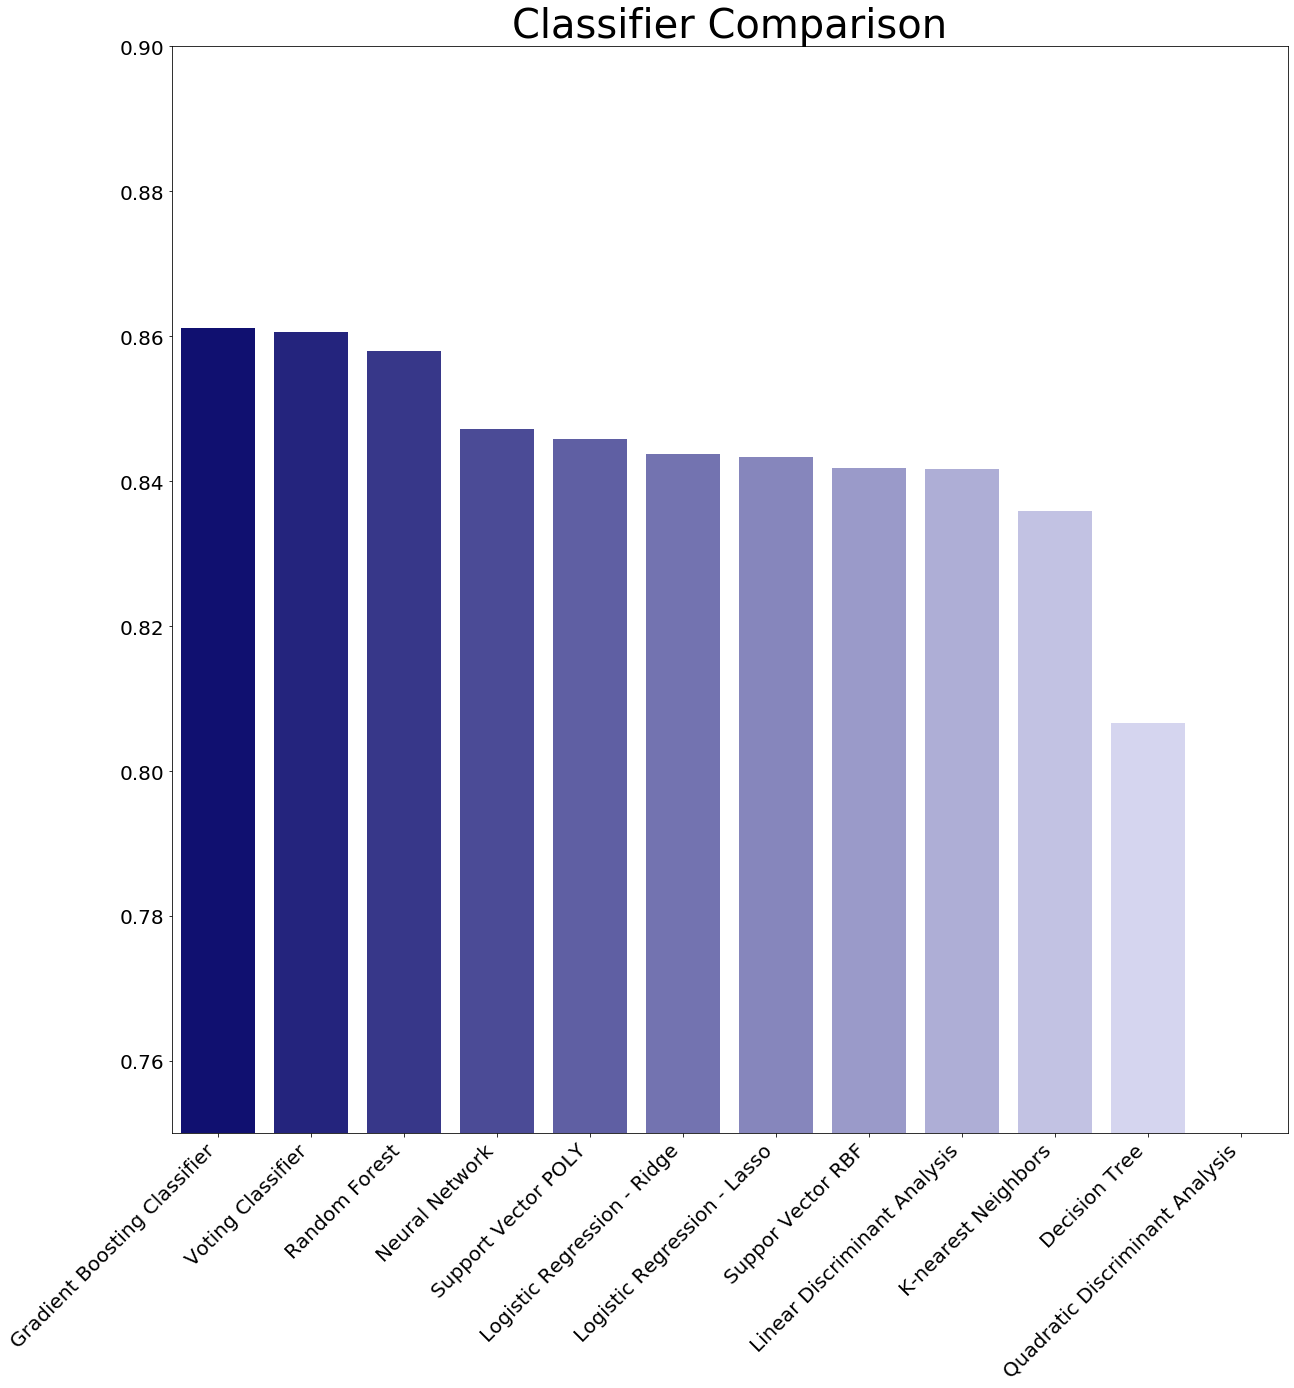

In [25]:
plt.figure(figsize=(20,20))
plt.xticks(rotation=45)
plt.ylim(.75, .9)
plt.title("Classifier Comparison", fontsize=40)
names = [x for _,x in sorted(zip(mean_scores,names))][::-1]
mean_scores = sorted(mean_scores)[::-1]
ax=sns.barplot(names, mean_scores, palette=sns.light_palette("navy",len(names),  reverse=True))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
    )

## Fine-Tune Models with Potentials

In [26]:
##Tune Random Forest
param_grid= {"n_estimators":[300], "min_samples_split":[22, 25, 27], "max_features":[7, 15, 25]}
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)
grid.fit(cleaned_train[predictors], cleaned_train[target])
grid.best_params_
grid.best_score_

0.8579601211406267

In [27]:
#Tune logistic regression
log_reg_lasso = LogisticRegressionCV(Cs = 20, cv = 5, penalty="l1", solver="saga" )
log_reg_lasso.fit(cleaned_train[predictors], cleaned_train[target])
cross_val_score(log_reg_lasso, cleaned_train[predictors], cleaned_train[target], cv =3)
cross_val_score(log_reg_lasso, cleaned_train[top_predictors], cleaned_train[target], cv =3)

array([0.84197264, 0.84015361, 0.84783391])

In [28]:
#Tune Support Vector Polynomial Kernel
svc_poly = SVC(kernel = "poly", gamma="scale")
param_grid= {"degree":[3], "probability": [False], "coef0": [10, 15], "C": [1, 5]}
grid = GridSearchCV(estimator=svc_poly, param_grid=param_grid,  cv=2)
grid.fit(cleaned_train[top_predictors], cleaned_train[target])
grid.best_params_
grid.best_score_

0.84668

In [29]:
#Tune RBF Kernel Support Vector Machine
svc = SVC(kernel = "rbf", gamma="scale")
param_grid= {"C": [10, 15, 30]}
grid = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3)
grid.fit(cleaned_train[predictors], cleaned_train[target])
grid.best_params_
grid.best_score_

0.8418801306887889

In [30]:
#Tune Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=500, max_features=20, max_depth=4)
param_grid= {"loss":["deviance"], "n_estimators":[200], "min_samples_split":[2], "max_depth":[4],"max_features":[20], "learning_rate":[.05,.1,.20] }
grid = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3)
grid.fit(cleaned_train[predictors], cleaned_train[target])
grid.best_params_
grid.best_score_

0.8640801403594421

Gradient Boosting Classifier works best

## Tune GBC Again as it is the best

### Test predictions on both binned and unbinned predictors with GBC

In [31]:
cleaned_all = prepare_data(full_train, target, bin_data = False)
all_predictors = [col for col in cleaned_all if col != target]

print(sum(cross_val_score(gbc, cleaned_train[predictors], cleaned_train[target], cv =7))/7)
print(sum(cross_val_score(gbc, cleaned_all[all_predictors], cleaned_train[target], cv =7))/7)

0.8641203685763681
0.8715601191291891


Unbinned was slightly better

### Tune GBC again on all predictors unbinned

In [32]:
gbc = GradientBoostingClassifier()
param_grid= {"loss":["deviance"], "n_estimators":[700], "min_samples_split":[2, 10, 20], "max_depth":[3, 4, 5],"max_features":[15, 20, 25] }
grid = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3)
grid.fit(cleaned_all[all_predictors], cleaned_train[target])
grid.best_params_
grid.best_score_

0.870040061981649

### Tune the number of estimators in GBC

In [33]:
gbc = GradientBoostingClassifier()
param_grid= {"loss":["deviance"], "n_estimators":[500, 700, 1000], "min_samples_split":[10], "max_depth":[4],"max_features":[20] }
grid = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3)
grid.fit(cleaned_all[all_predictors], cleaned_train[target])
grid.best_params_
grid.best_score_

0.8683600523766571

## Final Model (GBC)

In [34]:
gbc = GradientBoostingClassifier(n_estimators=700, max_features=20, max_depth=4, min_samples_split = 10)
##Fit final model
gbc.fit(cleaned_all[all_predictors], cleaned_train[target])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=20, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=700,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Prep Completely Separared Testing Data to Test Final Model

In [38]:
##Prepare data for final model (unbinned except country)
full_test = pd.read_csv("test2.csv")
cleaned_test = prepare_data(full_test, target = target, bin_data=False)

### Predict test value

In [39]:
predictions = gbc.predict(cleaned_test[all_predictors])
print("Model Accuracy: " + str(accuracy_score(cleaned_test[target], predictions)))

Model Accuracy: 0.8685774666490556


### Get Confusion Matrix

In [40]:
##Get confusion matrix
confusion_matrix(cleaned_test[target], predictions)
print(classification_report(cleaned_test[target], predictions, target_names = ["Income <= 50K","Income >= 50K" ]))

               precision    recall  f1-score   support

Income <= 50K       0.90      0.93      0.91      5712
Income >= 50K       0.77      0.67      0.71      1859

     accuracy                           0.87      7571
    macro avg       0.83      0.80      0.81      7571
 weighted avg       0.86      0.87      0.87      7571

